# Tarea M10 MPAD de González_Ramón

# Problema machine learning: Detección estilos de juego usando SVM


### Template para Desarrollo de Modelos siguiendo CRISP-DM

In [1]:
## Importación de bibliotecas necesarias

import numpy as np
import pandas as pd
import os
import json
import re
import io
from collections import defaultdict
from glob import glob
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.patches as mpatches

# Configuraciones
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# 1. Comprensión del Negocio

### <u>Contexto deportivo</u>

**Para este punto inicial quiero comenzar por explicar el contexto deportivo por el cual me he decidido a realizar un análisis de estilo de juego de los partidos del Atlético de Madrid durante la liga 2024/25.**

Este fútbol moderno ha evolucionado hacia un análisis cada vez más cuantitativo y basado en datos. Esto, antes era dominio exclusivo de la observación cualitativa y la intuición de expertos, hoy se complementa con análisis estadístico avanzado y modelos predictivos. En este contexto, el Atlético de Madrid representa un caso de estudio particularmente interesante para mi, donde cada partido es una muestra de la variabilidad en el estilo, idea, plan... o como queramos denominarlo, para minimizar al rival, y exponer las fortalezas propias.
Bajo la dirección técnica de Diego Simeone desde 2011, el Atlético ha mostrado una evolución táctica notable, pasando de un equipo reconocido principalmente por su solidez defensiva y juego directo, a un conjunto capaz de adaptar su estilo de juego según el contexto competitivo. Por eso, esta adaptabilidad es precisamente lo que hace valioso utilizar técnicas de machine learning para detectar, categorizar y analizar sus patrones tácticos.

### <u>Definición del Problema</u>

El problema que abordamos es la clasificación automática de los estilos de juego del Atlético de Madrid en cada partido de La Liga. Lo cual nos lleva a:

- Identificar, primero, las dimensiones tácticas relevantes que definen un estilo de juego (orientación ofensiva/defensiva, tipo de ataque, presión, etc.);
- Cuantificar estas dimensiones mediante métricas e índices objetivos perfectamente comprobables y que su elaboración sea exigente y eshaustiva;
- Considerar factores contextuales que pueden influir en el estilo adoptado (expulsiones, goles, lesiones...);
- Crear un sistema de clasificación que pueda asignar etiquetas de estilo para cada dimensión táctica, o al menos, se acerque lo más posible.

Este problema es fundamentalmente de clasificación multiclase y multidimensional, ya que para cada partido necesitamos categorizar el estilo en varias dimensiones independientes pero relacionadas.

### <u>Objetivo del Proyecto</u>

El objetivo principal es desarrollar un modelo SVM (Support Vector Machine) que permita:

1.- Clasificar automáticamente el estilo de juego del Atlético en cada partido según múltiples dimensiones tácticas, mediante la generación de Índices que nos ayuden a determinar:

- Orientación general (ofensivo, defensivo, equilibrado);
- Fase ofensiva (posicional, vertical, directo);
- Patrones de ataque (bandas, pasillo central);
- Intensidad defensiva (presión alta, defensa pasiva);
- Altura del bloque (alto, medio, bajo).


2.- Analizar la evolución táctica del equipo a lo largo de la temporada, identificando patrones y tendencias.
3.- Evaluar el impacto de factores contextuales como:

- Rival (categoría del oponente)
- Localía (jugar como local o visitante)
- Eventos clave (expulsiones, goles tempranos)
- Resultado parcial


4.- Proporcionar insights tácticos que puedan ser valiosos para análisis deportivo, periodismo especializado o entrenadores.

### <u>Justificación modelo SVM</u>

He elegido un modelo SVM (Support Vector Machine) fundamentalmente por los siguientes motivos:

- Su eficacia en espacios de alta dimensionalidad: SVM es particularmente efectivo cuando trabajamos con múltiples variables e índices tácticos, manteniendo buen rendimiento incluso cuando el número de características es elevado en comparación con el número de muestras (38 jornadas vs múltiples índices).
- Es capaz de establecer fronteras de decisión complejas: al usar diferentes kernels (lineal, RBF, polinómico), SVM puede capturar relaciones no lineales entre los índices tácticos y los estilos de juego, adaptándose a la complejidad que lleva dicho análisis táctico.
- Es muy robusto frente a posibles outliers: existen partidos con eventos atípicos (expulsiones tempranas, goleadas) pueden ser mejor manejados por SVM, especialmente con la adecuada configuración del parámetro de regularización C.
- Interpretabilidad con SVM lineal: si se usa un kernel lineal, se pueden interpretar los coeficientes del modelo para entender qué índices tienen mayor influencia en la clasificación de cada estilo.
- Y su versatilidad para problemas multiclase: con estrategias como "uno contra todos" (OvA) o "uno contra uno" (OvO), SVM puede abordar eficazmente la naturaleza multiclase de nuestro problema táctico.

### <u>Criterios de éxito</u>


El éxito del proyecto se evaluará según:

- Precisión de la clasificación: medida a través de métricas como accuracy, precision, recall y F1-score para cada dimensión táctica.
- Consistencia con el conocimiento experto: las clasificaciones deben tener sentido futbolístico y alinearse con análisis técnicos reconocidos.
- Capacidad para detectar adaptaciones tácticas: el modelo debe identificar cambios de estilo según el contexto (rival, resultado, etc.).
- Interpretabilidad de los resultados: los hallazgos deben ser fácilmente comprensibles para profesionales del deporte.
- Potencial analítico: las clasificaciones deben proporcionar insights valiosos sobre patrones tácticos temporada a temporada.

### <u>Recursos disponibles</u>

Para desarrollar este proyecto cuento con:

1.- Datos de eventos detallados por partido, por jornada (Ejemplo --> 1ª_VIL-ATM_EventData.csv):

- Coordenadas espaciales (x, y) de cada acción;
- Tipo de evento (pase, tiro, recuperación, etc.);
- Resultado de cada acción (exitosa/fallida);
- Atributos adicionales como longitud de pase, ángulo, etc.

2.- Datos contextuales y maestros:

- master_liga_atm.csv: información sobre partido con formato jornada, rival, resultado, expulsiones, minutos primer gol...
- stats_atm_por_partido.csv: estadísticas agregadas de cada partido, básicas como xG, pases completados...
- Métricas precalculadas: verticalidad, altura media del equipo.


3.- Índices tácticos que desarrollaremos:

- Índice de Iniciativa de Juego (IIJ);
- Índice de Volumen de Juego Ofensivo (IVJO);
- Índice de Progresión (EC);
- Índice de Eficacia en finalización (EF);
- Índice de Verticalidad (IV);
- Índice de Presión Alta (IPA);
- Índice de Juego Directo (IJD);
- Índice de Amplitud (IA);
- Índice de Densidad Defensiva (IDD);
- ¿Índice de Complejidad en el Juego? (ICJ).

# 2. Comprensión de los Datos

## 2.1 Carga de Datos

In [2]:
# Funciones que leen los archivos de datos de ATM

def cargar_datos():
    """
    Carga todos los datasets necesarios para el análisis y
    muestra información sobre su estructura y contenido
    
    Returns:
        dict: Diccionario con todos los datasets cargados
    """
    datasets = {}
    
    print("=== CARGA DE DATOS Y DESCRIPCIÓN DE FUENTES ===")
    
    # 1. Carga datos maestros de partidos
    print("\n1. Datos maestros de partidos (master_liga_atm.csv):")
    try:
        # Intento con diferentes separadores
        try:
            master_liga = pd.read_csv("data/stats_jornadas/master_liga_atm.csv", sep=';')
            if master_liga.shape[1] <= 1:  # Si solo hay una columna, se intenta con coma
                master_liga = pd.read_csv("data/stats_jornadas/master_liga_atm.csv")
        except:
            master_liga = pd.read_csv("data/stats_jornadas/master_liga_atm.csv")
        
        datasets['master_liga'] = master_liga
        print(f"   ✓ Archivo cargado correctamente: {master_liga.shape[0]} filas, {master_liga.shape[1]} columnas")
        
        # Información de columnas
        print("\n   Columnas disponibles:")
        for col in master_liga.columns:
            print(f"   - {col}: {master_liga[col].dtype}")
        
        # Primeras filas
        print("\n   Primeras 3 filas del dataset:")
        print(master_liga.head(3))
        
        print("\n   Descripción: Este archivo contiene información contextual de cada partido,")
        print("   incluyendo rival, resultado, métricas tácticas (altura media, verticalidad),")
        print("   y eventos clave (goles, expulsiones) con sus minutos.")
    except Exception as e:
        print(f"   ✗ Error al cargar master_liga_atm.csv: {e}")
    
    # 2. Estadísticas por partido
    print("\n2. Estadísticas por partido (stats_atm_por_partido.csv):")
    try:
        # Intento con diferentes enfoques de carga
        try:
            # Primero con punto y coma
            stats_partido = pd.read_csv("data/stats_jornadas/stats_atm_por_partido.csv", sep=';')
            
            # Si solo hay una columna, se intenta con coma
            if stats_partido.shape[1] <= 1:
                stats_partido = pd.read_csv("data/stats_jornadas/stats_atm_por_partido.csv")
        except:
            # Intentar directamente con coma
            stats_partido = pd.read_csv("data/stats_jornadas/stats_atm_por_partido.csv")
        
        datasets['stats_partido'] = stats_partido
        print(f"   ✓ Archivo cargado correctamente: {stats_partido.shape[0]} filas, {stats_partido.shape[1]} columnas")
        
        # Información de columnas
        print("\n   Columnas disponibles:")
        print("   " + ", ".join(stats_partido.columns.tolist()))
        
        # Primeras filas
        print("\n   Primeras 5 filas del dataset:")
        print(stats_partido.head(5))
        
        print("\n   Descripción: Este archivo contiene estadísticas detalladas por jornada,")
        print("   organizadas con métricas en columnas y cada jornada en cada fila. Incluye datos de")
        print("   posesión, pases, tiros, xG, y múltiples métricas ofensivas y defensivas.")
    except Exception as e:
        print(f"   ✗ Error al cargar stats_atm_por_partido.csv: {e}")  
        
    # 3. Busca y carga archivos de eventos de ejemplo
    print("\n3. Datos de eventos en una jornada:")
    
    # Busca en la estructura de carpetas correcta
    root_dir = "data/stats_jornadas"
    jornadas_encontradas = []
    
    # Busca archivos directamente en stats_jornadas
    try:
        for file in os.listdir(root_dir):
            if "EventData" in file:
                jornada = file.split('_')[0]
                if jornada not in jornadas_encontradas:
                    jornadas_encontradas.append(jornada)
    except:
        pass
    
    # Busca en carpetas de jornada si no encontramos directamente
    if not jornadas_encontradas:
        try:
            for item in os.listdir(root_dir):
                item_path = os.path.join(root_dir, item)
                if os.path.isdir(item_path) and "jornada" in item.lower():
                    for file in os.listdir(item_path):
                        if "EventData" in file:
                            jornada = item.replace("jornada_", "")
                            if jornada not in jornadas_encontradas:
                                jornadas_encontradas.append(jornada)
        except:
            pass
    
    if jornadas_encontradas:
        print(f"   ✓ Jornadas con datos disponibles: {', '.join(jornadas_encontradas)}")
        
        # Carga un ejemplo de la primera jornada encontrada
        ejemplo_jornada = jornadas_encontradas[0]
        
        # Determina la ruta correcta
        event_file_path = None
               
        # Busca en el directorio raíz
        for file in os.listdir(root_dir):
            file_path = os.path.join(root_dir, file)
            if os.path.isfile(file_path):
                if ejemplo_jornada in file and "EventData" in file:
                    event_file_path = file_path
        
        # Si no encontramos, buscar en carpetas de jornada
        if not event_file_path:
            jornada_dir = os.path.join(root_dir, f"jornada_{ejemplo_jornada}")
            if os.path.exists(jornada_dir):
                for file in os.listdir(jornada_dir):
                    file_path = os.path.join(jornada_dir, file)
                    if "EventData" in file:
                        event_file_path = file_path
        
        # Carga y muestra datos de eventos
        if event_file_path:
            try:
                # Intenta diferentes separadores
                try:
                    eventos = pd.read_csv(event_file_path, sep=';')
                    if eventos.shape[1] <= 1:  # Si solo hay una columna, con coma
                        eventos = pd.read_csv(event_file_path)
                except:
                    eventos = pd.read_csv(event_file_path)
                
                datasets['eventos_ejemplo'] = eventos
                print(f"\n   4.1. Datos de eventos (archivo: {os.path.basename(event_file_path)}):")
                print(f"   ✓ Dimensiones: {eventos.shape[0]} eventos, {eventos.shape[1]} columnas")
                
                # Muestra información de las columnas principales
                print("\n   Columnas principales:")
                main_cols = ['id', 'minute', 'teamId', 'x', 'y', 'type', 'outcomeType']
                for col in main_cols:
                    if col in eventos.columns:
                        print(f"   - {col}: {eventos[col].dtype}")
                
                # Muestra ejemplos de eventos
                print("\n   Primeros 3 eventos:")
                print(eventos.head(3))
                
                print("\n   Descripción: Este archivo contiene todos los eventos ocurridos durante el partido,")
                print("   con coordenadas espaciales (x,y), minuto, equipo, tipo de evento (pase, tiro, etc.)")
                print("   y resultado. Permite análisis detallado de patrones tácticos.")
            except Exception as e:
                print(f"   ✗ Error al cargar archivo de eventos: {e}")
        
    else:
        print("   ✗ No se encontraron archivos de eventos")

    # 4. Datos archivo master equipos liga
    print("\n4. Datos maestros de equipos (equipos_laliga_master.csv):")
    try:
        # Intenta con diferentes separadores
        try:
            equipos = pd.read_csv("data/master/equipos_laliga_master.csv", sep=';')
            if equipos.shape[1] <= 1:  # Si solo hay una columna, con coma
                equipos = pd.read_csv("data/master/equipos_laliga_master.csv")
        except:
            equipos = pd.read_csv("data/master/equipos_laliga_master.csv")
        
        datasets['equipos'] = equipos
        print(f"   ✓ Archivo cargado correctamente: {equipos.shape[0]} filas, {equipos.shape[1]} columnas")
        
        # Muestra información de columnas
        print("\n   Columnas disponibles:")
        for col in equipos.columns:
            print(f"   - {col}: {equipos[col].dtype}")
        
        # Muestra las primeras filas
        print("\n   Primeras 5 filas del dataset:")
        print(equipos.head(5))
        
        print("\n   Descripción: Este archivo contiene información de referencia sobre los equipos")
        print("   de La Liga, incluyendo nombres, identificadores y atributos que facilitan")
        print("   el mapeo con otros datasets.")
    except Exception as e:
        print(f"   ✗ Error al cargar equipos_laliga_master.csv: {e}")
    
    # Información final
    print("\n=== RESUMEN DE FUENTES DE DATOS ===")
    print("1. master_liga_atm.csv: Datos contextuales de partidos (38 jornadas)")
    print("2. stats_atm_por_partido.csv: Estadísticas detalladas por jornada")
    print("3. Archivos por jornada: Datos de eventos a nivel micro")
    print("4. equipos_laliga_master.csv: Información de referencia de equipos")
    
    print("\nCon estas fuentes complementarias, podremos analizar el estilo de juego del")
    print("Atlético de Madrid desde múltiples perspectivas: tácticas generales, patrones")
    print("ofensivos/defensivos y comportamiento espacial en el campo.")
    
    return datasets

# Cargar todos los datos disponibles
datos = cargar_datos()

# Asigno cada dataset a una variable independiente para facilitar la exploración 
df_master_liga = datos.get('master_liga')
df_stats_partido = datos.get('stats_partido') 
df_eventos_ej = datos.get('eventos_ejemplo')
df_equipos = datos.get('equipos')

print("\nDatasets asignados a variables individuales para exploración interactiva:")
print(f"- master_liga: {df_master_liga.shape if isinstance(df_master_liga, pd.DataFrame) else 'No disponible'}")
print(f"- stats_partido: {df_stats_partido.shape if isinstance(df_stats_partido, pd.DataFrame) else 'No disponible'}")
print(f"- eventos_ejemplo: {df_eventos_ej.shape if isinstance(df_eventos_ej, pd.DataFrame) else 'No disponible'}")
print(f"- equipos: {df_equipos.shape if isinstance(df_equipos, pd.DataFrame) else 'No disponible'}")

=== CARGA DE DATOS Y DESCRIPCIÓN DE FUENTES ===

1. Datos maestros de partidos (master_liga_atm.csv):
   ✓ Archivo cargado correctamente: 38 filas, 18 columnas

   Columnas disponibles:
   - jornada: object
   - formato_jornada: object
   - equipo_local: object
   - equipo_visitante: object
   - fecha: object
   - local_visitante: object
   - rival: object
   - resultado: object
   - altura_media: float64
   - verticalidad: object
   - goles_a_favor: float64
   - goles_en_contra: float64
   - min_primer_gol_a_favor: float64
   - min_primer_gol_en_contra: float64
   - expulsion_propia: float64
   - expulsion_rival: float64
   - min_expulsion_propia: float64
   - min_expulsion_rival: float64

   Primeras 3 filas del dataset:
  jornada formato_jornada        equipo_local    equipo_visitante       fecha  \
0      1ª      1ª_VIL-ATM       Villarreal CF  Atletico de Madrid  19/08/2024   
1      2ª      2ª_ATM-GIR  Atletico de Madrid           Girona FC  25/08/2024   
2      3ª      3ª_ATM-ES

**Carga de datos y muestra mínima de como tengo estructurados los 4 archivos que entiendo, utilizaremos para el proyecto**

## 2.2 Análisis Exploratorio


#### <u>Creo una función que expone la información de los archivos</u>

In [3]:
def analisis_exploratorio(df, nombre_df="Dataset"):
    """
    Realizar análisis exploratorio inicial
    
    Args:
        df: DataFrame a analizar
        nombre_df: Nombre descriptivo del DataFrame
    """
    print(f"\n=== ANÁLISIS EXPLORATORIO: {nombre_df} ===\n")
    
    # Info básica
    print("Información del Dataset:")
    print(df.info())
    
    # Estadísticas descriptivas (solo para columnas numéricas)
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_cols) > 0:
        print("\nEstadísticas Descriptivas (columnas numéricas):")
        print(df[numeric_cols].describe())
    
    # Valores faltantes
    print("\nValores Faltantes:")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
    else:
        print("No hay valores faltantes en el dataset")
    
    return None

# Aplico la función a cada uno de los dataframes
print("\n" + "="*70)
print("ANÁLISIS EXPLORATORIO DE DATOS")
print("="*70)

# Df master_liga
analisis_exploratorio(df_master_liga, "MASTER LIGA")

# Df stats_partido
analisis_exploratorio(df_stats_partido, "ESTADÍSTICAS POR PARTIDO")

# DF eventos_ejemplo (probando si está disponible)
if 'df_eventos_ej' in locals() and isinstance(df_eventos_ej, pd.DataFrame):
    analisis_exploratorio(df_eventos_ej, "EVENTOS EJEMPLO")
else:
    print("\n=== ANÁLISIS EXPLORATORIO: EVENTOS EJEMPLO ===\n")
    print("No hay datos de eventos disponibles para analizar")

# DF equipos
analisis_exploratorio(df_equipos, "EQUIPOS")


ANÁLISIS EXPLORATORIO DE DATOS

=== ANÁLISIS EXPLORATORIO: MASTER LIGA ===

Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   jornada                   38 non-null     object 
 1   formato_jornada           38 non-null     object 
 2   equipo_local              38 non-null     object 
 3   equipo_visitante          38 non-null     object 
 4   fecha                     29 non-null     object 
 5   local_visitante           38 non-null     object 
 6   rival                     38 non-null     object 
 7   resultado                 29 non-null     object 
 8   altura_media              29 non-null     float64
 9   verticalidad              29 non-null     object 
 10  goles_a_favor             29 non-null     float64
 11  goles_en_contra           29 non-null     float64
 12  min_primer_gol_a_fav

In [4]:
df_master_liga.head(3)

,jornada,formato_jornada,equipo_local,equipo_visitante,fecha,local_visitante,rival,resultado,altura_media,verticalidad,goles_a_favor,goles_en_contra,min_primer_gol_a_favor,min_primer_gol_en_contra,expulsion_propia,expulsion_rival,min_expulsion_propia,min_expulsion_rival
0,1ª,1ª_VIL-ATM,Villarreal CF,Atletico de Madrid,19/08/2024,V,Villarreal CF,2-2,50.46,44.27%,2.0,2.0,20.0,18.0,0.0,0.0,0.0,0.0
1,2ª,2ª_ATM-GIR,Atletico de Madrid,Girona FC,25/08/2024,L,Girona FC,3-0,49.84,45.89%,3.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0
2,3ª,3ª_ATM-ESP,Atletico de Madrid,RCD Español,28/08/2024,L,RCD Español,0-0,57.79,41.39%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_stats_partido.head(3)

,jornada,posesion,pases,pases_precisos,pases_campo_propio,pases_campo_rival,pases_largos_precisos,centros_precisos,toques_area_rival,regates_exitosos,tiros_totales,tiros_puerta,tiros_palos,tiros_fuera,tiros_bloqueados,tiros_bloqueados.1,tiros_bloqueados.2,tiros_bloqueados.3,tiros_bloqueados.4,tiros_bloqueados.5,tiros_bloqueados.6,tiros_bloqueados.7,tiros_dentro_area,tiros_fuera_area,xG,xG_juego_abierto,xG_balon_parado,xG_sin_penaltis,xG_porteria,ocasiones_claras,ocasiones_claras_falladas,duelos_ganados,duelos_suelo_ganados,duelos_aereos_ganados,entradas_exitosas,interceptaciones,despejes,tiros_bloqueados.8,tiros_bloqueados.9,tiros_bloqueados.10,tiros_bloqueados.11,tiros_bloqueados.12,tiros_bloqueados.13,tiros_bloqueados.14,tiros_bloqueados.15,paradas_portero,faltas_cometidas,corners,fueras_juego,saques_banda,tarj_amar,tarj_roj
0,1,55,592,519 (88%),304,215,19 (56%),7 (47%),24,8 (73%),9,4,1,4,1,2,1,2,1,2,1,2,7,2,1.11,1.09,0.02,1.11,0.38,3,2,39,31 (47%),8 (57%),9 (53%),2,9,1,2,1,2,1,2,1,2,2,12,3,2,19,3,0
1,2,42,462,404 (87%),214,190,28 (55%),1 (17%),19,5 (45%),11,6,0,2,3,5,3,5,3,5,3,5,6,5,1.22,1.09,0.13,1.22,1.43,1,0,46,38 (52%),8 (53%),15 (65%),10,33,3,5,3,5,3,5,3,5,4,11,1,2,15,1,0
2,3,62,595,523 (88%),223,300,29 (67%),9 (32%),39,6 (60%),25,7,1,10,8,0,8,0,8,0,8,0,18,7,2.47,1.98,0.48,2.47,1.36,5,5,42,25 (50%),17 (52%),8 (80%),5,15,8,0,8,0,8,0,8,0,1,6,9,6,28,0,0


In [6]:
df_eventos_ej.head(3)

,Unnamed: 0,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,relatedEventId,relatedPlayerId,cardType,isGoal
0,0,2.736476e+09,2,0,0.0,825,0.0,0.0,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 32, 'displayName': 'Start'}","{'value': 1, 'displayName': 'Successful'}",[],[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2.736476e+09,2,0,0.0,63,0.0,0.0,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 32, 'displayName': 'Start'}","{'value': 1, 'displayName': 'Successful'}",[],[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.736477e+09,3,0,0.0,825,49.2,50.0,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}","{'value': 1, 'displayName': 'Successful'}","[{'type': {'value': 213, 'displayName': 'Angle...","[91, 117, 30, 35, 37, 215, 218]",True,334221.0,33.2,51.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_equipos.head(3)

,nombre,shortname,id_streamlit,url_fbref,id_whoscored,id_fotmob,id_understat,id_sofascore,id_transfermarkt,ruta_escudo
0,Deportivo Alaves,ALA,1,https://fbref.com/es/equipos/8d6fd021/Estadist...,60,9866,https://understat.com/team/Alaves/2024,2885,1108,'assets/escudos/ala.png'
1,Atletico de Madrid,ATM,2,https://fbref.com/es/equipos/db3b9613/Estadist...,63,9906,https://understat.com/team/Atletico_Madrid/2024,2836,13,'assets/escudos/atm.png'
2,Athletic Club,ATH,3,https://fbref.com/es/equipos/2b390eca/Estadist...,53,8315,https://understat.com/team/Athletic_Club/2024,2825,621,'assets/escudos/ath.png'


#### <u>Conclusiones análisis exploratorio</u>

1. df_master_liga (master_liga_atm.csv): 
-   Faltantes porque solo se han disputado 29 jornadas, y el resto son de las que quedan por disputar.
-   Resultado está en object, y ver formatos o errroes, y crearé columna que certifique empate, victoria o derrota.
-   Verticalidad también está en object y debo pasarlo a numérico, y quitar el signo de porcentaje.
-   Resto de columnas numéricas quitar decimales, excepto verticalidad y altura media.

2. df_stats_partido (stats_atm_por_partido.csv):
-   Solo son 30 filas, por solo disputarse esos 29 partidos. 
-   Las filas de las siguientes variables (pases_precisos, pases_largos_precisos, centros_precisos, regates_exitosos, duelos_suelos_ganados, duelos_aereos_ganados, y entradas_exitosas) contienen tras el dato, y entre paréntesis, el porcentaje de éxito en dicha métrica. Se generarán las columnas nuevas con el signo % previo a la métrica en cuestión, y se extraerán los valores. Un ejemplo puede ser en la primera jornada que tiene este dato como "regates_exitosos" --> 8 (73%) , y la nueva variable llamada "%regates_exitosos" tendría este otro "73.0". 

3. df_eventos_ej (1ª_VIL-ATM_EventData.csv):
-   Aunque hay muchos eventos faltantes, para lo que haremos, que será filtrar y crear un archivo maestro que contenga la info deseada por partido, no sería necesario rellenar con números o eliminar.
-   Filtraremos por id de equipo (63 para el Atleti), y seleccionaremos las columnas que queremos (teamId, minute, second, x, y, type que cambiaré a tipo_evento, outcomeType que convertiré a resultado_evento más legible, endX y endY para los eventos que los tengan, isTouch).
-   Transformar el Json de la columna type, cuya información es básica para muchos de los datos.

4. df_equipos (equipos_laliga_master.csv):
-   No requiere transformaciones, ya que es solo para cruzar información.

## 2.3 Visualizaciones Iniciales

### <u>Visualizaciones elegidas</u>

1. Scatter plot donde lo primero que quiero mostrar es la relación entre verticalidad y altura media, y que se enfrenta con resultados de los partidos.
2. Heatmap de correlación para detectar esta en métricas clave, ayudando a detectar factores adyacentes.
3. Gráfico de líneas que igualmente nos mostrará la evolución táctica a lo largo de la temporada.
4. Box plots de comparativa para mostrar diferencias entre local y visitante.
5. Y repetir de nuevo otro Box Plot por ver qué métricas nos pueden ayudar a discriminar mejor entre victorias, empates y derrotas.

In [8]:
def visualizaciones_iniciales(datos):
    """
    Crear visualizaciones exploratorias para análisis táctico
    
    Args:
        datos: Diccionario con los datasets cargados (master_liga, stats_partido, etc.)
    """
    print("\n=== VISUALIZACIONES INICIALES DE ANÁLISIS TÁCTICO ===\n")
    
    # 1. Scatter plot: Verticalidad vs Altura Media
    print("1. Visualización de relación entre verticalidad y altura media")
    if 'master_liga' in datos:
        df = datos['master_liga'].copy()
        
        if 'verticalidad' in df.columns and 'altura_media' in df.columns:
            sns.set_style("whitegrid", {'grid.color': '#E6E6E6'})
            
            df['verticalidad_num'] = df['verticalidad'].str.rstrip('%').astype(float)
            
            df['resultado_tipo'] = df.apply(
                lambda row: 'Victoria' if row['goles_a_favor'] > row['goles_en_contra'] 
                else ('Empate' if row['goles_a_favor'] == row['goles_en_contra'] else 'Derrota'),
                axis=1
            )
            
            colors = {'Victoria': 'green', 'Empate': '#ff7f0e', 'Derrota': 'red'}
            
            # Scatter plot
            plt.figure(figsize=(12, 8), facecolor="#E6E6E6")
            ax = plt.gca()
            
            for resultado, grupo in df.groupby('resultado_tipo'):
                plt.scatter(
                    grupo['verticalidad_num'], grupo['altura_media'],
                    label=resultado, color=colors[resultado], alpha=0.7, s=100,
                    edgecolor='darkblue', linewidth=1.5
                )
            
            # Añado etiquetas de jornada
            for _, row in df.iterrows():
                plt.annotate(
                    f"{row['formato_jornada']}", 
                    (row['verticalidad_num'], row['altura_media']),
                    xytext=(5, 0), textcoords='offset points',
                    fontsize=9, color='darkblue', fontweight='bold'
                )
            
            # Fondo y bordes
            ax.set_facecolor('white')
            for spine in ax.spines.values():
                spine.set_color('darkblue')
                spine.set_linewidth(1)
            
            # Personalizo cuadrícula
            ax.grid(True, color='lightgray', linestyle='-', alpha=0.7)
            
            # Títulos y etiquetas
            plt.title('Relación entre verticalidad y altura media', fontsize=16, color='darkblue', fontweight='bold')
            plt.xlabel('Verticalidad (%)', fontsize=14, color='darkblue')
            plt.ylabel('Altura Media', fontsize=14, color='darkblue')
            plt.tick_params(axis='both', colors='darkblue')
            
            # Leyenda
            legend = plt.legend(title='Resultado', frameon=True, labelcolor='darkblue')
            legend.get_frame().set_edgecolor('darkblue')
            legend.get_frame().set_linewidth(1)
            plt.setp(legend.get_title(), color='darkblue')
            
            plt.tight_layout()
            plt.show()
    
    # 2. Heatmap de correlación entre métricas clave
    print("\n2. Heatmap de correlación entre métricas tácticas clave")
    if 'stats_partido' in datos:
        try:
            stats = datos['stats_partido'].copy()
            
            # Métricas elegidas
            metricas_clave = ['posesion', 'pases', 'pases_campo_rival','toques_area_rival', 'tiros_totales', 'xG', 'duelos_ganados', 'interceptaciones']
            
            # Dataframe de correlación
            df_corr = pd.DataFrame()
            
            for col in metricas_clave:
                if col in stats.columns:
                    
                    df_corr[col] = pd.to_numeric(stats[col], errors='coerce')
            
            if not df_corr.empty:
                # Calculo de matriz
                corr_matrix = df_corr.corr()
                
                sns.set_style("white")
                
                # Visualizar heatmap
                plt.figure(figsize=(10, 8), facecolor="#E6E6E6")
                ax = plt.gca()
                
                # Mask para mostrar solo la mitad superior
                mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
                
                heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, 
                            fmt='.2f', mask=mask, cbar_kws={"shrink": .8})
                
                for _, spine in ax.spines.items():
                    spine.set_visible(True)
                    spine.set_color('darkblue')
                    spine.set_linewidth(1.5)
                
                cbar = heatmap.collections[0].colorbar
                cbar.ax.tick_params(colors='darkblue')
                plt.title('Correlación entre métricas elegidas', fontsize=16, color='darkblue', 
                        fontweight='bold')
                plt.xticks(color='darkblue', fontweight='bold')
                plt.yticks(color='darkblue', fontweight='bold')
                
                for pos in ['top', 'bottom', 'right', 'left']:
                    plt.gca().spines[pos].set_color('darkblue')
                    plt.gca().spines[pos].set_linewidth(1)
                
                plt.tight_layout()
                plt.show()
        except Exception as e:
            print(f"Error al crear heatmap: {e}")
    
    # 3. Gráfico de líneas: Evolución táctica
    print("\n3. Gráfico de evolución de métricas tácticas a lo largo de la temporada")
    if 'stats_partido' in datos and 'master_liga' in datos:
        try:
            sns.set_style("whitegrid", {'grid.color': '#E6E6E6'})
            
            stats = datos['stats_partido'].copy()
            
            # Métricas de interés
            metricas_evolucion = ['posesion', 'xG']
            
            # Creación figura
            plt.figure(figsize=(14, 8), facecolor="#E6E6E6")
            ax = plt.gca()
            
            for metrica in metricas_evolucion:
                if metrica in stats.columns:
                    valores = pd.to_numeric(stats[metrica], errors='coerce')
                    plt.plot(valores.index, valores, 'o-', linewidth=2, label=metrica,
                            marker='o', markersize=8, markeredgecolor='darkblue', markeredgewidth=1.5)
            
            # Verticalidad desde master_liga
            df_master = datos['master_liga'].copy()
            df_master['jornada_num'] = pd.to_numeric(df_master['jornada'].str.replace('ª', ''), errors='coerce')
            df_master['verticalidad_num'] = df_master['verticalidad'].str.rstrip('%').astype(float)
            
            # Orden por jornada
            df_master = df_master.sort_values('jornada_num')
            
            # Plot de verticalidad
            plt.plot(df_master['jornada_num'], df_master['verticalidad_num'], 'o-', 
                    linewidth=2, label='Verticalidad (%)',
                    marker='o', markersize=8, markeredgecolor='darkblue', markeredgewidth=1.5)
            
            # Se añade referencia de resultados
            for i, row in df_master.iterrows():
                color = 'green' if row['goles_a_favor'] > row['goles_en_contra'] else ('blue' if row['goles_a_favor'] == row['goles_en_contra'] else 'red')
                plt.axvline(x=row['jornada_num'], color=color, alpha=0.2)
            
            # Fondo y los bordes
            ax.set_facecolor('white')
            for spine in ax.spines.values():
                spine.set_color('darkblue')
                spine.set_linewidth(1.5)
            
            plt.grid(True, axis='both', color='lightgray', linestyle='-', alpha=0.7)
            
            # Título y etiquetas
            plt.title('Evolución de métricas durante la temporada', fontsize=16, 
                    color='darkblue', fontweight='bold')
            plt.xlabel('Jornada', fontsize=14, color='darkblue')
            plt.ylabel('Valor', fontsize=14, color='darkblue')
            plt.tick_params(axis='both', colors='darkblue')
            
            legend = plt.legend(frameon=True)
            legend.get_frame().set_edgecolor('darkblue')
            legend.get_frame().set_linewidth(1)
            
            plt.xticks(df_master['jornada_num'])
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error al crear gráfico de evolución: {e}")
    
    # 4. Box plot comparativas local-visitante
    print("\n4. Comparación de métricas si local o visitante")
    if 'master_liga' in datos and 'stats_partido' in datos:
        try:
            df_master = datos['master_liga'].copy()
            df_master['jornada_num'] = pd.to_numeric(df_master['jornada'].str.replace('ª', ''), errors='coerce')
            
            stats = datos['stats_partido'].copy()
            
            # Unión de datasets
            df_unidos = pd.merge(
                df_master[['jornada_num', 'local_visitante']], 
                stats, 
                left_on='jornada_num', 
                right_index=True,
                how='inner'
            )
            
            # Métricas para comparar
            metricas_comparar = ['posesion', 'pases', 'xG', 'duelos_ganados', 'despejes', 'faltas_cometidas']
            metricas_disponibles = [m for m in metricas_comparar if m in df_unidos.columns]
            
            if metricas_disponibles:
                # Estilo
                sns.set_style("whitegrid", {'grid.color': '#E6E6E6'})
                
                # Figura
                plt.figure(figsize=(12, 6), facecolor="#E6E6E6")
                
                # Subplots
                n_cols = 3
                n_rows = (len(metricas_disponibles) + 1) // 3
                
                for i, metrica in enumerate(metricas_disponibles, 1):
                    ax = plt.subplot(n_rows, n_cols, i)
                    
                    df_unidos[metrica] = pd.to_numeric(df_unidos[metrica], errors='coerce')
                    
                    boxplot = sns.boxplot(x='local_visitante', y=metrica, data=df_unidos,
                                order=['L', 'V'], palette={'L': 'darkgreen', 'V': 'red'}, 
                                flierprops={'markerfacecolor': 'darkblue', 'markersize': 6})
                    
                    # Todos los elementos del boxplot
                    for patch in ax.artists:
                        r, g, b, a = patch.get_facecolor()
                        patch.set_edgecolor('darkblue')
                        patch.set_linewidth(1)
                    
                    for line in ax.get_lines():
                        line.set_color('darkblue')
                        line.set_linewidth(1)
                    
                    ax.set_facecolor('white')
                    for spine in ax.spines.values():
                        spine.set_color('darkblue')
                        spine.set_linewidth(1)
                    
                    ax.grid(True, axis='y', color='lightgray', linestyle='-', alpha=0.7)
                    
                    # Título y etiquetas
                    ax.set_title(f'{metrica}', fontsize=12, color='darkblue', weight='bold')
                    ax.set_xlabel('')
                    ax.set_ylabel('')
                    ax.tick_params(axis='both', colors='darkblue')
                
                plt.suptitle('Comparación de Métricas según Localía', fontsize=16, color='darkblue', weight='bold')
                plt.tight_layout()
                plt.subplots_adjust(top=0.9)
                plt.show()
            else:
                print("No se encontraron las métricas necesarias para la comparación")
        except Exception as e:
            print(f"Error al crear visualización por localía: {e}")
    else:
        print("No se encuentran los datasets necesarios")
    
    # 5. Box plots por resultado
    print("\n5. Distribución de métricas según resultado")
    if 'master_liga' in datos and 'stats_partido' in datos:
        try:
            df_master = datos['master_liga'].copy()
            df_master['jornada_num'] = pd.to_numeric(df_master['jornada'].str.replace('ª', ''), errors='coerce')
            
            # Columna de resultado
            df_master['resultado_tipo'] = df_master.apply(
                lambda row: 'Victoria' if row['goles_a_favor'] > row['goles_en_contra'] 
                else ('Empate' if row['goles_a_favor'] == row['goles_en_contra'] else 'Derrota'),
                axis=1
            )
            
            stats = datos['stats_partido'].copy()
            
            # Unión de datasets
            df_unidos = pd.merge(
                df_master[['jornada_num', 'resultado_tipo']], 
                stats, 
                left_on='jornada_num', 
                right_index=True,
                how='inner'
            )
            
            # Columnas a numérico
            numeric_cols = ['posesion', 'xG', 'tiros_totales', 'duelos_ganados']
            available_cols = [col for col in numeric_cols if col in df_unidos.columns]
            
            if available_cols:
                # Estilo
                sns.set_style("whitegrid", {'grid.color': '#E6E6E6'})
                
                for col in available_cols:
                    df_unidos[col] = pd.to_numeric(df_unidos[col], errors='coerce')
                
                # Visualización
                plt.figure(figsize=(12, 6), facecolor="#E6E6E6")
                
                for i, col in enumerate(available_cols, 1):
                    ax = plt.subplot(2, 2, i)
                    
                    # Boxplot con personalización
                    boxplot = sns.boxplot(x='resultado_tipo', y=col, data=df_unidos, 
                                palette={'Victoria': 'green', 'Empate': '#ff7f0e', 'Derrota': 'red'},
                                flierprops={'markerfacecolor': 'darkblue', 'markersize': 6})
                    
                    # Elementos del boxplot
                    for patch in ax.artists:
                        r, g, b, a = patch.get_facecolor()
                        patch.set_edgecolor('darkblue')
                        patch.set_linewidth(1)
                    
                    for line in ax.get_lines():
                        line.set_color('darkblue')
                        line.set_linewidth(1)
                    
                    ax.set_facecolor('white')
                    for spine in ax.spines.values():
                        spine.set_color('darkblue')
                        spine.set_linewidth(1)
                    
                    ax.grid(True, axis='y', color='lightgray', linestyle='-', alpha=0.7)
                    
                    # Título y etiquetas
                    ax.set_title(f'{col}', fontsize=14, color='darkblue', weight='bold')
                    ax.set_xlabel('')
                    ax.set_ylabel('')
                    ax.tick_params(axis='both', colors='darkblue')
                
                plt.suptitle('Distribución de métricas según resultado', fontsize=16, color='darkblue', weight='bold')
                plt.tight_layout()
                plt.subplots_adjust(top=0.9)
                plt.show()
            else:
                print("No se encontraron las métricas necesarias para el análisis")
        except Exception as e:
            print(f"Error al crear boxplots por resultado: {e}")
    else:
        print("No se encuentran los datasets necesarios")

    print("\n=== VISUALIZACIONES COMPLETADAS ===")
    return


=== VISUALIZACIONES INICIALES DE ANÁLISIS TÁCTICO ===

1. Visualización de relación entre verticalidad y altura media


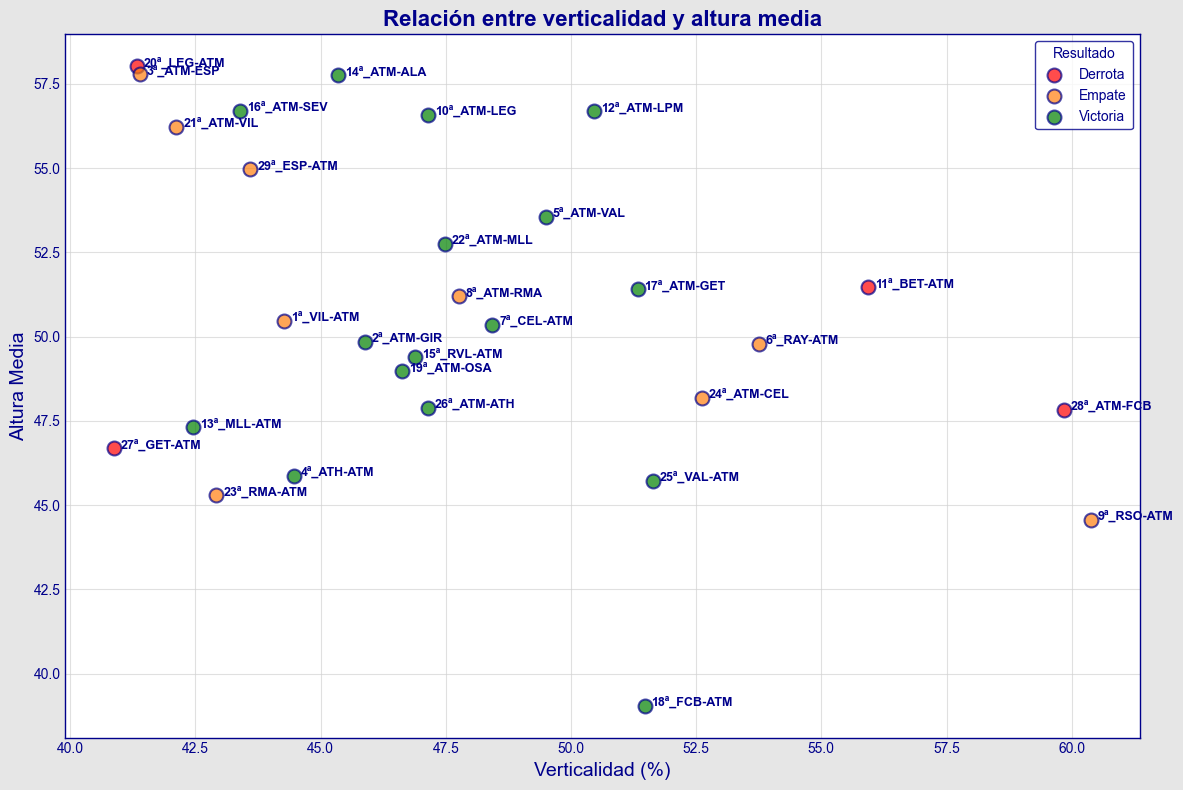


2. Heatmap de correlación entre métricas tácticas clave


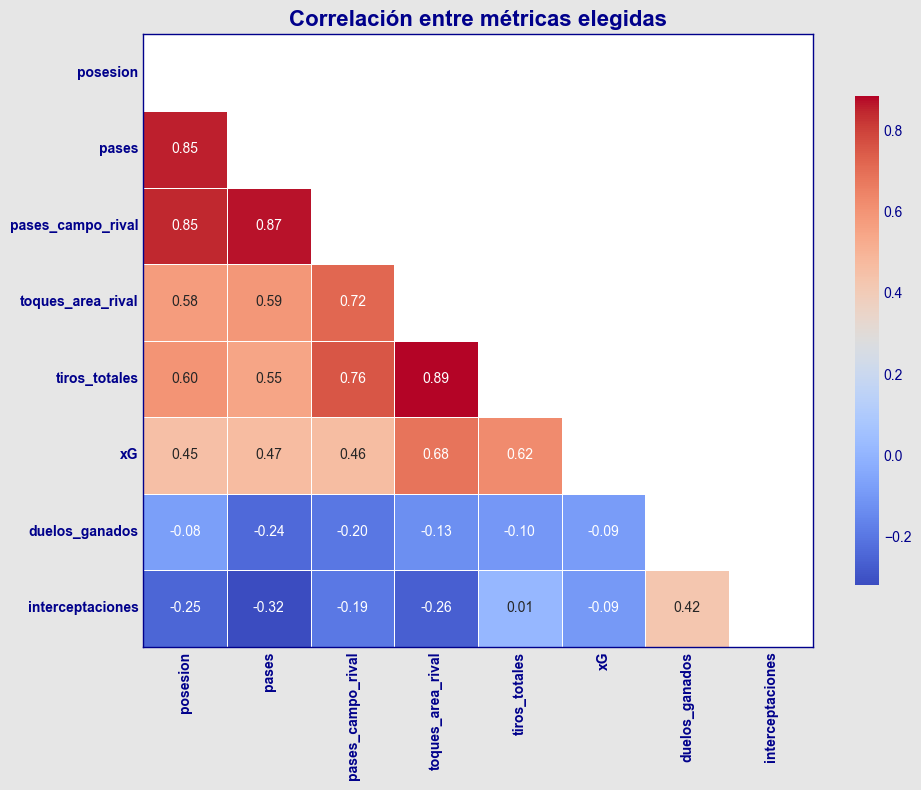


3. Gráfico de evolución de métricas tácticas a lo largo de la temporada


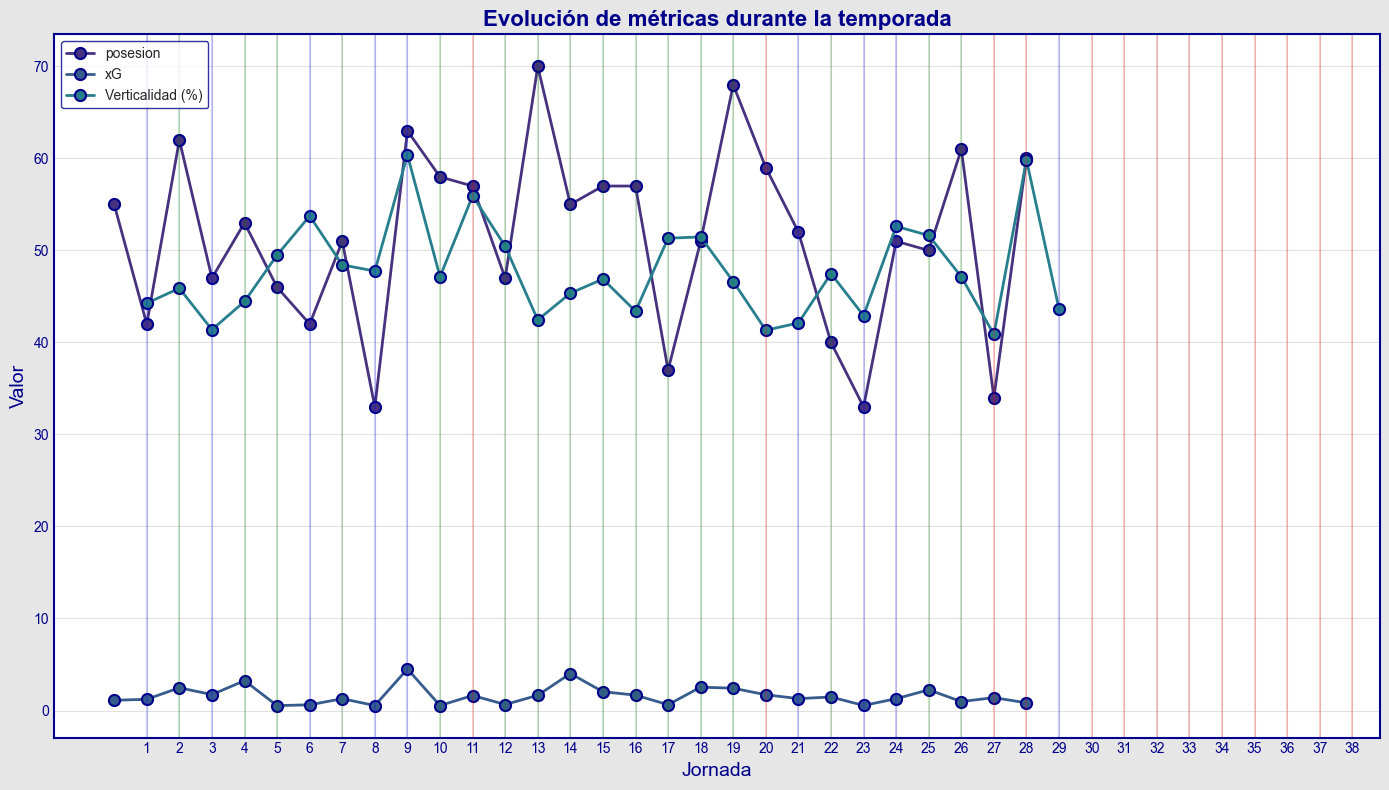


4. Comparación de métricas si local o visitante


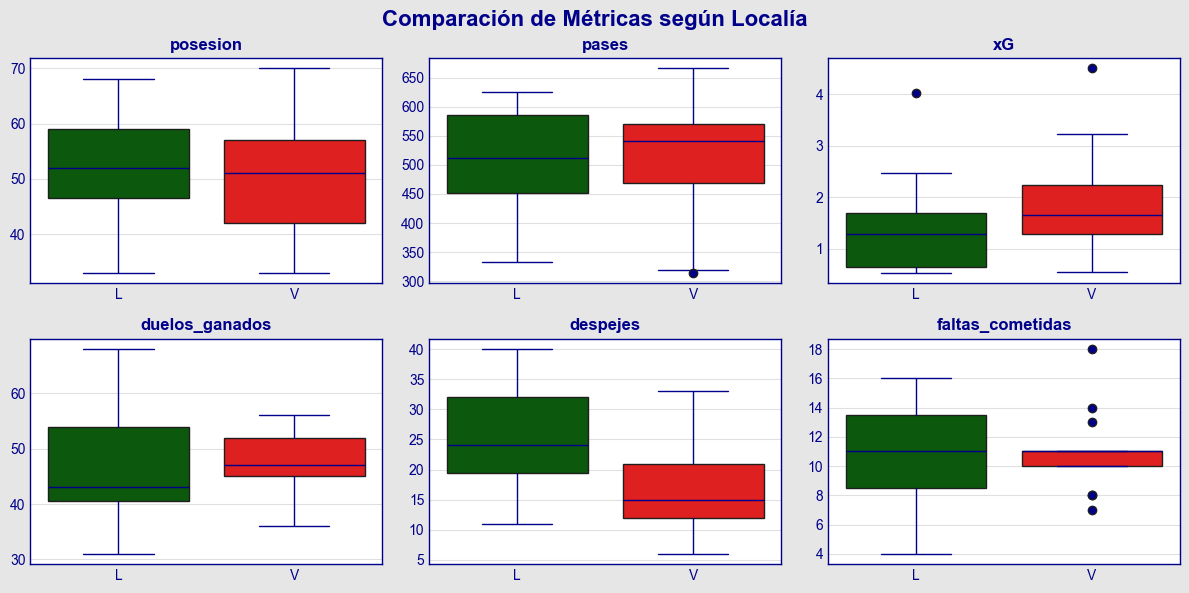


5. Distribución de métricas según resultado


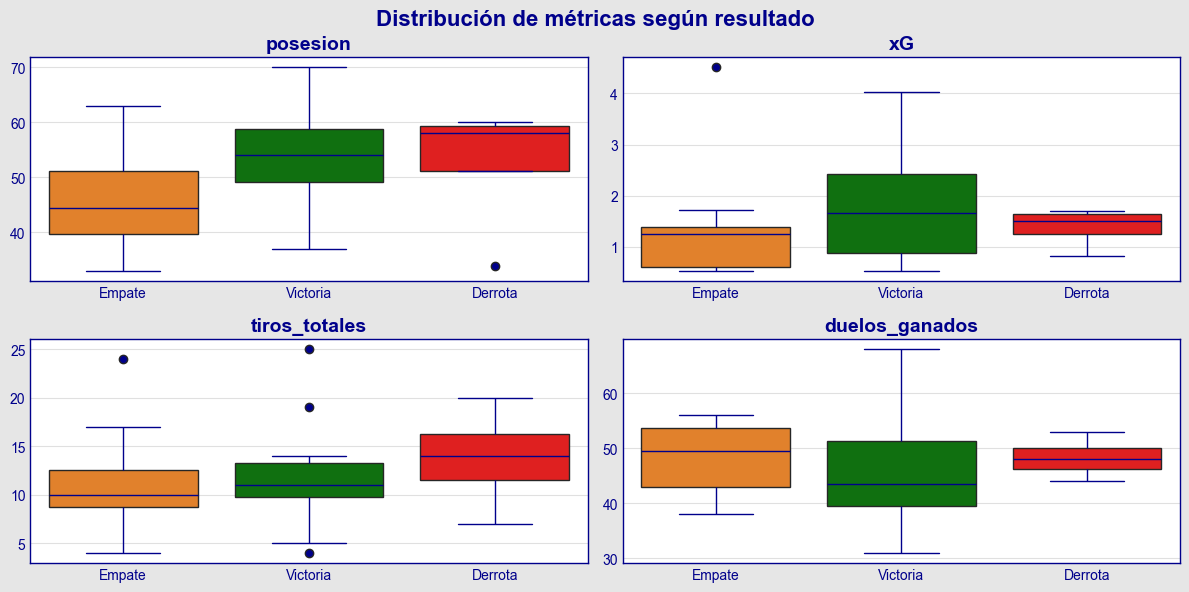


=== VISUALIZACIONES COMPLETADAS ===


In [9]:
# Ejecutar visualizaciones
visualizaciones_iniciales(datos)

### <u>Conclusiones extraidas de las visualizaciones</u>

1. **Scatter Plot: Relación entre verticalidad y altura media**
- Elección de visualización y métricas:
Este scatter plot es perfecto para identificar la relación entre dos variables continuas fundamentales para determinar el estilo de juego: la verticalidad (tendencia a avanzar rápidamente hacia la portería rival) y la altura media del equipo en el campo (vinculada a presión alta o bloque bajo). El uso de colores para distinguir los resultados añade una tercera dimensión informativa.

- Análisis de resultado:
Se observa una amplia dispersión de puntos, lo que sugiere que el Atlético de Madrid adapta su estilo de juego según el contexto.
Las victorias (verde) tienden a mostrar una verticalidad moderada (45-52%) con altura media variable, y una agrupación más cercana entre puntos.
Las derrotas (rojo) presentan patrones más extremos: muy alta verticalidad (FCB, 28ª jornada) o muy baja altura (GET, 27ª jornada), aunque son menos, 4, y ante rivales y contextos muy variados.
Los partidos con Barcelona (tanto local como visitante) muestran estilos opuestos: altura muy baja pero verticalidad extrema como visitante (18ª), y verticalidad alta manteniendo posición más alta como local (28ª).

- Utilidad para el modelo SVM:
Esta visualización es crucial para identificar los diferentes "clusters" de estilos de juego. Las coordenadas en este espacio bidimensional pueden ser características importantes para el SVM, permitiendo separar diferentes enfoques tácticos.

2. **Heatmap: Correlación entre métricas elegidas**
- Elección de visualización y métricas:
El heatmap es la visualización ideal para mostrar correlaciones entre múltiples variables. Las métricas seleccionadas cubren aspectos ofensivos (posesión, pases, toques en área) y defensivos (duelos, interceptaciones).

- Análisis de resultado:
Fuerte correlación positiva entre posesión, pases y pases en campo rival (0.85-0.87), lo que es esperable.
Alta correlación entre toques en área rival y tiros totales (0.89), vinculando penetración y finalización.
Correlación negativa entre métricas ofensivas (posesión, pases) y defensivas (duelos, interceptaciones), lo que sugiere estilos de juego diferenciados (posesión vs. contraataque).
El xG muestra correlaciones moderadas con métricas ofensivas, indicando que la eficacia no siempre está ligada al volumen ofensivo. Punto importante a tener en cuenta.

- Utilidad para el modelo SVM:
Esta matriz permite identificar variables colineales que podrían reducirse para evitar redundancia en el modelo SVM. Por ejemplo, podría seleccionarse solo una entre posesión/pases/pases_campo_rival debido a su alta correlación.

3. **Gráfico de líneas: Evolución de métricas durante la temporada**
- Elección de visualización y métricas:
El gráfico de líneas es perfecto para visualizar evolución temporal. Incluir posesión, xG y verticalidad permite ver cambios en enfoque táctico a lo largo de las jornadas.

- Análisis de lo observado:
Gran variabilidad en la posesión (desde 33% hasta 70%), mostrando adaptabilidad táctica.
La verticalidad muestra menor variación, manteniendo un rango más constante (40-60%).
El xG se mantiene generalmente bajo (0-5), con picos en jornadas específicas.
Las líneas verticales verdes/rojas permiten contextualizar los cambios según resultados.
Se aprecian periodos con patrones tácticos similares, seguidos de cambios abruptos, muy contextualizados por rivales.

- Utilidad para el modelo SVM:
Esta visualización ayuda a identificar posibles agrupaciones temporales (periodos con estilos similares) que podrían usarse para crear variables categóricas en el modelo SVM, como "fase de temporada".

4. **Boxplots: Comparación de métricas según localía**
- Elección de visualización y métricas:
Los boxplots son ideales para comparar distribuciones entre grupos. Comparar métricas entre partidos como local (L) y visitante (V) revela adaptaciones tácticas según el contexto.

- Análisis de lo observado:
Mayor posesión y xG como local, reflejando un enfoque más dominante.
Sorprendentemente, los pases totales son similares como local y visitante.
Hay, como es lógico, más despejes como visitante, indicando un enfoque más defensivo.
Más faltas cometidas como visitante, sugiriendo mayor intensidad defensiva.
Los duelos ganados se mantienen relativamente constantes, aunque con mayor variabilidad como visitante.

- Utilidad para el modelo SVM:
La variable "local_visitante" podría ser un factor importante para el modelo SVM. La interacción entre localía y otras métricas tácticas podría capturarse mediante términos de interacción en el modelo.

5. **Boxplots: Distribución de métricas según resultado**
- Elección de visualización y métricas:
Similar al anterior, estos boxplots permiten analizar cómo varían las métricas según el resultado (victoria, empate, derrota).

- Análisis de lo observado:
Mayor posesión en derrotas, lo que parece contraintuitivo pero sugiere que el equipo es más efectivo sin dominar tanto el balón, o que tras verse por detrás en el marcador, adopta mayor iniciativa en dicho dominio.
Mayor xG en victorias, indicando mejor calidad de ocasiones cuando se gana. También relacionado con lo anterior, es decir, si se adelanta en el marcador, evoluciona a un ataque más selectivo.
Menor número de tiros en derrotas, a pesar de la mayor posesión. Puede clarificar un estilo de mayor eficiencia con espacios en ataques cortos y verticales.
Duelos ganados similares en victorias y derrotas, pero menores en empates.

- Utilidad para el modelo SVM:
Estas relaciones sugieren que el Atlético tiene diferentes patrones de éxito. El modelo SVM podría beneficiarse de características que capturen la "eficiencia" (ratio entre xG y posesión, por ejemplo), más que valores absolutos.

### <u>Toma de decisión final</u>

**Basado en estas visualizaciones, sería recomendable:**

- Variables clave para el modelo SVM:

Verticalidad y altura media como variables fundamentales;
Eficiencia ofensiva (xG/posesión, tiros/posesión);
Variables de contexto (local/visitante);
Métricas defensivas (despejes, duelos ganados).

- Reducción de dimensionalidad:

Eliminar variables altamente correlacionadas (usar solo una de: posesión, pases, pases_campo_rival);
Considerar la creación de índices compuestos (ofensivo, defensivo, transición).

- Posibles clasificaciones de estilo:

Posesión dominante: alta posesión, alto xG, altura media alta;
Contraataque vertical: baja posesión, alta verticalidad, xG moderado;
Bloque bajo defensivo: baja altura media, bajos valores ofensivos, altos despejes;
Presión alta agresiva: alta altura media, duelos ganados altos, posesión moderada.

    Importante añadir que aún queda por unir un csv de eventos, donde podremos observar aspectos como saques de puerta o faltas en primer tercio de campo para medir el impacto de reinicios en corto, o coordenadas en ataques para observar pasillos ofensivos como patrón común.

# 3. Preparación de Datos

## 3.1 Limpieza de Datos

In [10]:
# Proceso de limpieza de los archivos

def limpiar_datos(ruta_master, ruta_stats, ruta_eventos, ruta_equipos=None, mostrar_ejemplos=True):
    """
    Realiza la limpieza integral de todos los datasets necesarios para el análisis
    táctico del Atlético de Madrid.
    
    Args:
        ruta_master (str): Ruta al archivo master_liga_atm.csv
        ruta_stats (str): Ruta al archivo stats_atm_por_partido.csv
        ruta_eventos (str): Ruta a la carpeta que contiene los archivos de eventos por jornada
        ruta_equipos (str, opcional): Ruta al archivo equipos_laliga_master.csv
        mostrar_ejemplos (bool): Si es True, muestra las primeras filas de cada DataFrame
    
    Returns:
        dict: Diccionario con todos los DataFrames limpios
    """
    print("Iniciando proceso de limpieza de datos...")
    resultado = {}
    
    # 1. master_liga_atm.csv
    print("\n1. Limpieza de datos maestros de partidos...")
    df_master = limpiar_df_master(ruta_master)
    resultado['master'] = df_master
    
    # 2. stats_atm_por_partido.csv
    print("\n2. Limpieza de estadísticas por partido...")
    df_stats = limpiar_df_stats(ruta_stats)
    resultado['stats'] = df_stats
    
    # 3. Limpieza y combinación de archivos de eventos
    print("\n3. Procesando archivos de eventos por jornada...")
    df_eventos = limpiar_df_eventos(ruta_eventos)
    resultado['eventos'] = df_eventos
    
    # 4. equipos_laliga_master.csv
    if ruta_equipos:
        print("\n4. Procesando datos de equipos...")
        df_equipos = limpiar_df_equipos(ruta_equipos)
        resultado['equipos'] = df_equipos
    
    # Muestro info detallada de cada DataFrame
    if mostrar_ejemplos:
        for nombre, df in resultado.items():
            print(f"\n{'='*20} ANÁLISIS DETALLADO DE {nombre.upper()} {'='*20}")
            
            # Dimensiones
            print(f"\n📊 Dimensiones: {df.shape} (filas, columnas)")
            
            # Tipos de datos y valores no nulos
            print("\n📋 Información del DataFrame:")
            buffer = io.StringIO()
            df.info(buf=buffer)
            print(buffer.getvalue())
            
            # Estadísticas descriptivas para columnas numéricas
            try:
                print("\n📈 Estadísticas descriptivas (columnas numéricas):")
                print(df.describe())
            except:
                print("No se pudieron generar estadísticas descriptivas")
            
            # Valores únicos para columnas categóricas
            print("\n🔍 Valores únicos en columnas categóricas:")
            cat_cols = df.select_dtypes(include=['object']).columns
            for col in cat_cols[:5]:  # 5 por no saturar salida
                try:
                    n_unique = df[col].nunique()
                    print(f"{col}: {n_unique} valores únicos")
                    if n_unique < 10:  # Solo se muestra si hay pocos valores únicos
                        try:
                            unique_vals = df[col].unique()
                            # Se convierte a string para evitar problemas con diccionarios
                            print(f"    Valores: {[str(val)[:50] + '...' if isinstance(val, str) and len(str(val)) > 50 else str(val) for val in unique_vals]}")
                        except:
                            print("    No se pueden mostrar los valores únicos")
                except:
                    print(f"{col}: No se puede determinar valores únicos (posiblemente contiene tipos no hashables)")
            
            # Datos faltantes
            print("\n⚠️ Análisis de datos faltantes:")
            missing = df.isnull().sum()
            missing = missing[missing > 0]
            if len(missing) > 0:
                print(missing)
            else:
                print("No hay datos faltantes")
            
            # Primeras filas
            print("\n👀 Primeras 5 filas:")
            print(df.head(5))
            
            print(f"\n{'='*70}")
    
    print("\nProceso de limpieza completado con éxito.")
    return resultado

def limpiar_df_master(ruta_archivo):
    """
    Limpia el archivo master_liga_atm.csv
    
    Args:
        ruta_archivo (str): Ruta al archivo
    
    Returns:
        pd.DataFrame: DataFrame limpio
    """
    print(f"Leyendo archivo {ruta_archivo}...")
    df = pd.read_csv(ruta_archivo, sep=';')
    
    print("Aplicando transformaciones a datos maestros...")
    # Jornada a numérico
    df['jornada_num'] = df['jornada'].str.replace('ª', '').astype(int)
    
    # Verticalidad a numérico extrayendo símbolo de porcentaje
    df['verticalidad_num'] = df['verticalidad'].str.rstrip('%').astype(float)
    
    # Extraigo componentes del resultado
    df[['goles_favor_res', 'goles_contra_res']] = df['resultado'].str.split('-', expand=True).astype(float)
    
    # Se verifica coherencia entre resultado y goles
    mask_inconsistencia = (df['goles_favor_res'] != df['goles_a_favor']) | (df['goles_contra_res'] != df['goles_en_contra'])
    if mask_inconsistencia.any():
        print(f"ADVERTENCIA: Se encontraron {mask_inconsistencia.sum()} inconsistencias entre resultado y goles registrados")
    
    # Se crea la columna de resultado tipo (Victoria, Empate, Derrota)
    df['resultado_tipo'] = 'Sin disputar'
    mask_jugados = ~df['resultado'].isna()
    
    df.loc[mask_jugados & (df['goles_a_favor'] > df['goles_en_contra']), 'resultado_tipo'] = 'Victoria'
    df.loc[mask_jugados & (df['goles_a_favor'] == df['goles_en_contra']), 'resultado_tipo'] = 'Empate'
    df.loc[mask_jugados & (df['goles_a_favor'] < df['goles_en_contra']), 'resultado_tipo'] = 'Derrota'
    
    # Creo columnas para clasificar expulsiones según el minuto
    df['impacto_expulsion_propia'] = 0
    df.loc[df['min_expulsion_propia'] <= 30, 'impacto_expulsion_propia'] = 3  # Alta
    df.loc[(df['min_expulsion_propia'] > 30) & (df['min_expulsion_propia'] <= 60), 'impacto_expulsion_propia'] = 2  # Media
    df.loc[df['min_expulsion_propia'] > 60, 'impacto_expulsion_propia'] = 1  # Baja
    
    df['impacto_expulsion_rival'] = 0
    df.loc[df['min_expulsion_rival'] <= 30, 'impacto_expulsion_rival'] = 3  # Alta
    df.loc[(df['min_expulsion_rival'] > 30) & (df['min_expulsion_rival'] <= 60), 'impacto_expulsion_rival'] = 2  # Media
    df.loc[df['min_expulsion_rival'] > 60, 'impacto_expulsion_rival'] = 1  # Baja
    
    # Crear columnas para goles tempranos
    df['gol_temprano_favor'] = (df['min_primer_gol_a_favor'] <= 15) & (~df['min_primer_gol_a_favor'].isna())
    df['gol_temprano_contra'] = (df['min_primer_gol_en_contra'] <= 15) & (~df['min_primer_gol_en_contra'].isna())
    
    return df

def limpiar_df_stats(ruta_archivo):
    """
    Limpia el archivo stats_atm_por_partido.csv
    
    Args:
        ruta_archivo (str): Ruta al archivo
    
    Returns:
        pd.DataFrame: DataFrame limpio
    """
    print(f"Leyendo archivo {ruta_archivo}...")
    df = pd.read_csv(ruta_archivo)
    
    print("Aplicando transformaciones a estadísticas por partido...")
    # Lista de columnas que necesitan extracción de porcentajes
    columnas_con_porcentaje = [
        'pases_precisos', 'pases_largos_precisos', 'centros_precisos', 
        'regates_exitosos', 'duelos_suelo_ganados', 'duelos_aereos_ganados', 
        'entradas_exitosas'
    ]
    
    # Función para extraer valor numérico y porcentaje
    def extraer_valor_porcentaje(valor):
        if isinstance(valor, str) and '(' in valor:
            match = re.search(r'(\d+)\s*\((\d+(?:\.\d+)?)%\)', valor)
            if match:
                return int(match.group(1)), float(match.group(2))
        # Si no se puede extraer, devuelve el valor original y None
        return valor, None
    
    # Procesar columnas con porcentajes
    for col in columnas_con_porcentaje:
        if col in df.columns:
            # Se crea nueva columna para el porcentaje
            nuevo_col = f"pct_{col}"
            
            # Extrae valor y porcentaje
            valores_porcentajes = df[col].apply(extraer_valor_porcentaje)
            
            # Se asignan valores y porcentajes a sus respectivas columnas
            df[col] = valores_porcentajes.apply(lambda x: x[0])
            df[nuevo_col] = valores_porcentajes.apply(lambda x: x[1])
    
    # Elimino duplicados en columnas de tiros_bloqueados
    columnas_duplicadas = [col for col in df.columns if col.startswith('tiros_bloqueados.')]
    if columnas_duplicadas:
        print(f"Eliminando {len(columnas_duplicadas)} columnas duplicadas de tiros_bloqueados")
        df = df.drop(columns=columnas_duplicadas)
    
    # Convierto todas las columnas numéricas a float
    columnas_numericas = df.columns.drop('jornada')
    for col in columnas_numericas:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except:
            print(f"No se pudo convertir la columna {col} a numérico")
    
    # Me aseguro de que jornada es numérica
    df['jornada'] = pd.to_numeric(df['jornada'], errors='coerce')
    
    # Orden por jornada
    df = df.sort_values('jornada')
    
    return df

def limpiar_df_eventos(ruta_carpeta):
    """
    Limpia y combina todos los archivos de eventos por jornada
    
    Args:
        ruta_carpeta (str): Ruta a la carpeta con archivos de eventos
    
    Returns:
        pd.DataFrame: DataFrame combinado y limpio de eventos
    """
    print(f"Buscando archivos de eventos en {ruta_carpeta}...")
    # Obtengo primero la lista de archivos de eventos
    archivos_eventos = glob(os.path.join(ruta_carpeta, '*_EventData.csv'))
    print(f"Se encontraron {len(archivos_eventos)} archivos de eventos")
    
    if not archivos_eventos:
        print("ADVERTENCIA: No se encontraron archivos de eventos")
        return pd.DataFrame()
    
    # Función para extraer número de jornada del nombre de archivo
    def extraer_jornada(nombre_archivo):
        match = re.search(r'(\d+)ª?_', os.path.basename(nombre_archivo))
        if match:
            return int(match.group(1))
        return None
    
    # Lista para almacenar DataFrames procesados
    dfs_eventos = []
    
    # Procesa cada archivo
    for archivo in archivos_eventos:
        jornada = extraer_jornada(archivo)
        if jornada is None:
            print(f"ADVERTENCIA: No se pudo extraer número de jornada para {archivo}")
            continue
        
        print(f"Procesando eventos de jornada {jornada}...")
        
        # Lee el archivo
        df = pd.read_csv(archivo)
        
        # Extrae información de columnas JSON
        df = procesar_json_eventos(df)
        
        # Filtrar eventos del Atlético
        df_atletico = df[df['teamId'] == 63].copy()

        # Filtrar tiros y goles del rival
        df_tiros_rival = df[(df['teamId'] != 63) & 
                            (df['type_nombre'].isin(['Shot', 'Goal']))].copy()

        # Marcar estos eventos como "del rival" para distinguirlos
        df_tiros_rival['es_rival'] = True

        # Combinar ambos DataFrames
        df_eventos_filtrados = pd.concat([df_atletico, df_tiros_rival])

        # Añadir columna para identificar eventos del Atlético vs rival
        if 'es_rival' not in df_eventos_filtrados:
            df_eventos_filtrados.loc[df_eventos_filtrados['teamId'] == 63, 'es_rival'] = False
        
        # Añade columna de jornada
        df_eventos_filtrados['jornada'] = jornada
        
        # Ordena por minuto y segundo
        df_eventos_filtrados = df_eventos_filtrados.sort_values(['minute', 'second'])
        
        # Añade al listado
        dfs_eventos.append(df_eventos_filtrados)
    
    # Combina todos los DataFrames
    if dfs_eventos:
        print("Combinando todos los archivos de eventos...")
        df_eventos_completo = pd.concat(dfs_eventos, ignore_index=True)
        print(f"DataFrame de eventos combinado: {df_eventos_completo.shape}")
        return df_eventos_completo
    else:
        print("ADVERTENCIA: No se procesó ningún archivo de eventos correctamente")
        return pd.DataFrame()

def procesar_json_eventos(df):
    """
    Procesa columnas JSON en el DataFrame de eventos
    
    Args:
        df (pd.DataFrame): DataFrame con eventos
    
    Returns:
        pd.DataFrame: DataFrame con columnas JSON procesadas
    """
    # Columnas que contienen JSON
    columnas_json = ['period', 'type', 'outcomeType', 'qualifiers']
    
    # Procesar cada columna JSON
    for columna in columnas_json:
        if columna in df.columns:
            # Extraer valores directamente en lugar de mantener el diccionario
            if columna != 'qualifiers':  # qualifiers es una lista, no un diccionario
                try:
                    # Extrae el valor
                    df[f'{columna}_valor'] = df[columna].apply(
                        lambda x: json.loads(x.replace("'", '"'))['value'] 
                        if isinstance(x, str) else None)
                    
                    # Extrae el nombre
                    df[f'{columna}_nombre'] = df[columna].apply(
                        lambda x: json.loads(x.replace("'", '"'))['displayName'] 
                        if isinstance(x, str) else None)
                except:
                    print(f"Error al procesar la columna {columna}")
            else:
                # Para 'qualifiers', que es una lista, simplemente guardamos la longitud
                df[f'{columna}_longitud'] = df[columna].apply(
                    lambda x: len(json.loads(x.replace("'", '"')))
                    if isinstance(x, str) else 0)
    
    # Elimina columnas originales JSON
    df = df.drop(columns=columnas_json, errors='ignore')
    
    return df

def limpiar_df_equipos(ruta_archivo):
    """
    Limpia el archivo equipos_laliga_master.csv
    
    Args:
        ruta_archivo (str): Ruta al archivo
    
    Returns:
        pd.DataFrame: DataFrame limpio
    """
    print(f"Leyendo archivo {ruta_archivo}...")
    df = pd.read_csv(ruta_archivo, sep=';')
    
    print("Aplicando transformaciones a datos de equipos...")
    # Limpia nombres de columnas
    df.columns = df.columns.str.strip()
    
    # Limpia valores de rutas de escudos (quitar comillas)
    if 'ruta_escudo' in df.columns:
        df['ruta_escudo'] = df['ruta_escudo'].str.replace("'", "")
    
    return df

# Uso
if __name__ == "__main__":
    # Defino rutas (ajustar cada uno según corresponda)
    ruta_master = "data/stats_jornadas/master_liga_atm.csv"
    ruta_stats = "data/stats_jornadas/stats_atm_por_partido.csv"
    ruta_eventos = "data/stats_jornadas/"
    ruta_equipos = "data/master/equipos_laliga_master.csv"
    
    # Ejecutamos limpieza
    datos_limpios = limpiar_datos(ruta_master, ruta_stats, ruta_eventos, ruta_equipos)
    
    # Muestra información de los DataFrames limpios
    for nombre, df in datos_limpios.items():
        print(f"\n--- {nombre.upper()} ---")
        print(f"Dimensiones: {df.shape}")
        print("Primeras filas:")
        print(df.head())

Iniciando proceso de limpieza de datos...

1. Limpieza de datos maestros de partidos...
Leyendo archivo data/stats_jornadas/master_liga_atm.csv...
Aplicando transformaciones a datos maestros...
ADVERTENCIA: Se encontraron 18 inconsistencias entre resultado y goles registrados

2. Limpieza de estadísticas por partido...
Leyendo archivo data/stats_jornadas/stats_atm_por_partido.csv...
Aplicando transformaciones a estadísticas por partido...
Eliminando 15 columnas duplicadas de tiros_bloqueados

3. Procesando archivos de eventos por jornada...
Buscando archivos de eventos en data/stats_jornadas/...
Se encontraron 29 archivos de eventos
Procesando eventos de jornada 10...
Procesando eventos de jornada 11...
Procesando eventos de jornada 12...
Procesando eventos de jornada 13...
Procesando eventos de jornada 14...
Procesando eventos de jornada 15...
Procesando eventos de jornada 16...
Procesando eventos de jornada 17...
Procesando eventos de jornada 18...
Procesando eventos de jornada 19...

#### <u>Resumen limpieza</u>


1. master_liga_atm.csv: 

Eliminamos "ª" de la columna jornada y simbolo de porcentaje en columna de verticalidad y se pasa a numéricos. Se extrae valores de resultado y compara con goles, y se crea columna de victoria-empate-derrota. Generamos columna de impacto de expulsiones o goles en minutos iniciales.

2. stats_atm_por_partido: 

Se generan columnas nuevas con los porcentajes que encontramos en algunos datos con la medida del acierto, con el prefijo "pct", se eliminan columnas duplicadas, y ordenamos por jornada.

3. Limpieza, trato archivos de eventos: 

Se revisan los archivos existentes, y extrayendo el número de jornada de cada nombre, se unen por orden. Se analizan y filtramos por id del Atleti (63) y solo dejamos acciones de tiro rival para calcular alguno de los índices, y extraemos la info de cada celda con contenido en formato json creando nuevas columnas.

## 3.2 Feature Engineering

### <u>¿Qué voy a intentar hacer?</u>

En el siguiente código tomaré los datos limpios que he procesado en la fase anterior y trataré de generar índices tácticos que caracterizan el estilo de juego del Atlético de Madrid en cada partido. El proceso se divide en varias partes:

1. Procesamiento espacial: dividir el campo en zonas y clasificar los eventos según dónde ocurren (zona1/zona2/zona3 y derecho/central/izquierdo).

2. Cálculo de índices básicos usando estadísticas generales para calcular:

- IIJ (Índice de Iniciativa de Juego);
- IVJO (Índice de Volumen de Juego Ofensivo);
- EC (Índice de Eficacia en Construcción);
- EF (Índice de Eficacia en Finalización);
- IJD (Índice de Juego Directo).

3. Cálculo de índices avanzados, los cuáles requieren un análisis detallado de eventos:

- IER (Índice de Eficacia Recuperadora);
- IV (Índice de Verticalidad);
- IPA (Índice de Presión Alta);
- IA (Índice de Amplitud en ataque);
- IDD (Índice de Densidad Defensiva);
- ICJ (Índice de Complejidad de Juego).

3. Variables de contexto que muestran información adicional sobre cada partido:

- Expulsión temprana;
- Gol temprano a favor/en contra;
- Categoría del rival;
- Local/visitante.

4. Categorización de estilos basada en los índices, clasificando el estilo de juego en cada partido según:

- Orientación general (ofensivo, defensivo, equilibrado);
- Fase ofensiva (posicional, vertical, directo);
- Patrón de ataque (bandas, central, mixto);
- Intensidad defensiva (presión alta, defensa pasiva, moderada);
- Altura del bloque (alto, medio, bajo);
- Tipo de transición (contragolpe efectivo, convencional).

5. Preparación para modelado y organizar los datos para alimentar el modelo SVM:

- Normaliza las características numéricas;
- Prepara variables dependientes (y) para cada categoría de estilo;
- Prepara variables independientes (X) con todos los índices tácticos.

In [11]:
# Función creación de features
def crear_features(datos_limpios):
    """
    Realiza feature engineering a partir de los datos limpios para analizar
    el estilo de juego del Atlético de Madrid.
    
    Args:
        datos_limpios (dict): Diccionario con DataFrames limpios:
            - 'master': DataFrame con datos de partidos
            - 'stats': DataFrame con estadísticas por partido
            - 'eventos': DataFrame con eventos detallados
            - 'equipos': DataFrame con información de equipos
    
    Returns:
        pd.DataFrame: DataFrame con índices tácticos y features derivadas por jornada
    """
    print("Iniciando proceso de feature engineering...")
    
    # DF's
    df_master = datos_limpios['master']
    df_stats = datos_limpios['stats']
    df_eventos = datos_limpios['eventos']
    df_equipos = datos_limpios['equipos']
    
    # DF para almacenar todos los índices
    df_indices = pd.DataFrame()
    
    # Info espacial de eventos
    print("\n1. Procesando información espacial de eventos...")
    df_zonas = procesar_zonas_campo(df_eventos)
    
    # Calculo de índices tácticos básicos
    print("\n2. Calculando índices tácticos básicos...")
    df_indices_basicos = calcular_indices_basicos(df_master, df_stats)
    
    # Calculo de índices tácticos avanzados (basados en eventos)
    print("\n3. Calculando índices tácticos avanzados...")
    df_indices_avanzados = calcular_indices_avanzados(df_eventos, df_zonas, df_stats)
    
    # Calculo de variables de contexto
    print("\n4. Calculando variables de contexto...")
    df_contexto = calcular_variables_contexto(df_master, df_equipos)
    
    # Combinar dataframes básicos y avanzados primero
    print("\n5. Combinando índices básicos y avanzados...")
    # Asegurar que todos los DF tengan 'jornada' como clave
    if 'jornada' not in df_indices_basicos.columns:
        df_indices_basicos['jornada'] = df_indices_basicos.index

    if 'jornada' not in df_indices_avanzados.columns:
        df_indices_avanzados['jornada'] = df_indices_avanzados.index

    # Primero combinar índices básicos y avanzados
    df_combinado = pd.merge(df_indices_basicos, df_indices_avanzados, on='jornada', how='outer')

    # Se incorpora df_zonas para las estadísticas espaciales
    df_combinado = pd.merge(df_combinado, df_zonas, on='jornada', how='left')

    # Después se añaden las estadísticas generales para cálculos adicionales
    df_combinado = pd.merge(df_combinado, df_stats, on='jornada', how='left')

    # Y se calculan los índices especializados
    print("\n6. Calculando índices tácticos especializados...")
    df_indices_especializados = calcular_indices_especializados(df_combinado)

    # Lista de DF's a combinar para el resultado final
    print("\n7. Integrando todos los índices y variables...")
    dfs_to_combine = [df_indices_basicos, df_indices_avanzados, df_indices_especializados, df_contexto]

    # Combino los DF para obtener el resultado final
    df_indices = dfs_to_combine[0]
    for df in dfs_to_combine[1:]:
        df_indices = pd.merge(df_indices, df, on='jornada', how='outer')

    # AÑADIR ESTAS LÍNEAS: Asegurar que posesion esté en el DataFrame final
    if 'posesion' not in df_indices.columns and 'posesion' in df_combinado.columns:
        df_indices = pd.merge(df_indices, df_combinado[['jornada', 'posesion']], on='jornada', how='left')

    # Ordenar por jornada
    df_indices = df_indices.sort_values('jornada')
    
    # Se visualizan resultados
    print("\n8. Creando visualizaciones de índices...")
    visualizar_indices(df_indices)
    
    # Categorización de estilos de juego
    print("\n9. Categorizando estilos de juego...")
    df_indices = categorizar_estilos(df_indices)
    
    print("\nProceso de feature engineering completado.")
    return df_indices

# Función que customiza las distintas zonas del campo, y definen métricas asociadas a esta customización
def procesar_zonas_campo(df_eventos):
    """
    Procesa eventos para clasificarlos por zonas del campo
    
    Args:
        df_eventos (pd.DataFrame): DataFrame con eventos
    
    Returns:
        pd.DataFrame: DataFrame con eventos clasificados por zonas
    """
    print("  Clasificando eventos por zonas del campo...")
    
    df = df_eventos.copy()
    
    # Clasificación de zonas
    def clasificar_zona_vertical(x):
        if x <= 33.3:
            return 'Zona1'
        elif x <= 66.6:
            return 'Zona2'
        else:
            return 'Zona3'
    
    def clasificar_zona_horizontal(y):
        if y <= 25:
            return 'Derecho'
        elif y <= 75:
            return 'Central'
        else:
            return 'Izquierdo'
    
    # Funciones para clasificación
    df['zona_vertical'] = df['x'].apply(clasificar_zona_vertical)
    df['zona_horizontal'] = df['y'].apply(clasificar_zona_horizontal)
    
    # Se combinan las zonas para crear una zona completa
    df['zona_completa'] = df['zona_vertical'] + '_' + df['zona_horizontal']
    
    # Identificación pases progresivos (avance vertical significativo)
    df['es_pase_progresivo'] = False
    
    # Sólo pases
    mask_pases = df['type_nombre'] == 'Pass'
    
    # Determinar si son progresivos (avanzan al menos 10 unidades en x)
    df.loc[mask_pases & ~df['endX'].isna(), 'es_pase_progresivo'] = (
        df.loc[mask_pases & ~df['endX'].isna(), 'endX'] - 
        df.loc[mask_pases & ~df['endX'].isna(), 'x'] > 10
    )
    
    # Identificación pases largos (distancia euclidiana > 30 unidades)
    df['es_pase_largo'] = False
    
    # Calculamos distancia para pases con coordenadas completas
    mask_coord_completas = mask_pases & ~df['endX'].isna() & ~df['endY'].isna()
    
    if mask_coord_completas.any():
        df.loc[mask_coord_completas, 'distancia_pase'] = np.sqrt(
            (df.loc[mask_coord_completas, 'endX'] - df.loc[mask_coord_completas, 'x'])**2 +
            (df.loc[mask_coord_completas, 'endY'] - df.loc[mask_coord_completas, 'y'])**2
        )
        
        # Marcar pases largos
        df.loc[mask_coord_completas & (df['distancia_pase'] > 30), 'es_pase_largo'] = True    
    
    # Identificar recuperaciones
    recuperaciones = ['Interception', 'BallRecovery', 'Tackle', 'BlockedPass', 'Challenge']
    df['es_recuperacion'] = df['type_nombre'].isin(recuperaciones)
    
    # Identificar acciones defensivas
    acciones_defensivas = recuperaciones + ['Clearance', 'Block', 'Save', 'Claim']
    df['es_accion_defensiva'] = df['type_nombre'].isin(acciones_defensivas)
    
    # Identificar acciones en área propia (primer 20% del campo)
    df['en_area_propia'] = df['x'] <= 20
    
    # Identificar secuencias de posesión
    print("  Identificando secuencias de posesión...")
    recuentos_secuencias = identificar_secuencias_posesion(df)

    # Obtener estadísticas por jornada
    print("  Generando estadísticas espaciales por jornada...")
    df_zonas = generar_stats_espaciales(df, recuentos_secuencias)
    
    # Extraer tiros recibidos para calcular impacto con otras métricas
    print("  Extrayendo tiros recibidos...")
    # Filtrar eventos de tipo 'Shot' (o 'Goal') que no son del Atlético (teamId != 63)
    tiros_rival = df_eventos[(df_eventos['teamId'] != 63) & 
                            (df_eventos['type_nombre'].isin(['Shot', 'Goal']))]
    
    # Conteo por jornada
    tiros_recibidos_por_jornada = tiros_rival.groupby('jornada').size().reset_index()
    tiros_recibidos_por_jornada.columns = ['jornada', 'tiros_recibidos']
    
    # Se añade esta columna al DF de estadísticas espaciales
    df_zonas = pd.merge(df_zonas, tiros_recibidos_por_jornada, on='jornada', how='left')
    df_zonas['tiros_recibidos'].fillna(0, inplace=True)
    
    return df_zonas

# Función para calcular secuencias de posesión que considero importantes (mínimo ocho pases) y que llevaré al índice de control del juego
def identificar_secuencias_posesion(df):
    """
    Identifica secuencias de posesión en los eventos y devuelve recuentos
    
    Args:
        df (pd.DataFrame): DataFrame con eventos
    
    Returns:
        dict: Diccionario con recuentos de secuencias por jornada
    """
    # Diccionario para almacenar recuentos por jornada
    recuentos = {}
    
    # Proceso por jornada
    for jornada in df['jornada'].unique():
        print(f"  Procesando secuencias en jornada {jornada}...")
        
        df_jornada = df[df['jornada'] == jornada].copy()
        df_jornada = df_jornada.sort_values(['minute', 'second'])
        
        # Variables para seguimiento
        id_secuencia_actual = 1
        secuencias_largas = 0
        total_secuencias = 0
        pases_en_secuencia_actual = 0
        
        # Eventos que llevan a una interrupción y/o secuenia
        eventos_quiebre = ['Interception', 'Foul', 'OffsidePass', 'Offside', 'Save', 'Goal', 'Clearance']
        eventos_secuencia = ['Pass']
        
        # Iterar ordenadamente
        prev_idx = None
        
        for idx, row in df_jornada.iterrows():
            es_evento_secuencia = row['type_nombre'] in eventos_secuencia
            
            # Si hay quiebre o gap de tiempo
            if (row['type_nombre'] in eventos_quiebre or 
                (prev_idx is not None and 
                 ((df_jornada.loc[prev_idx, 'minute'] != row['minute']) or 
                  (df_jornada.loc[prev_idx, 'minute'] == row['minute'] and 
                   row['second'] - df_jornada.loc[prev_idx, 'second'] > 10)))):
                
                # Finalizar secuencia anterior si existía
                if pases_en_secuencia_actual > 0:
                    total_secuencias += 1
                    if pases_en_secuencia_actual >= 8:
                        secuencias_largas += 1
                
                # Iniciar nueva
                id_secuencia_actual += 1
                pases_en_secuencia_actual = 1 if es_evento_secuencia else 0
            else:
                # Continuar con la actual
                if es_evento_secuencia:
                    pases_en_secuencia_actual += 1
            
            prev_idx = idx
        
        # Procesar la última
        if pases_en_secuencia_actual > 0:
            total_secuencias += 1
            if pases_en_secuencia_actual >= 8:
                secuencias_largas += 1
        
        # Se guardan los recuentos
        recuentos[jornada] = {'secuencias_largas': secuencias_largas, 'total_secuencias': total_secuencias}
        print(f"    Identificadas {secuencias_largas} secuencias largas de {total_secuencias} totales")
    
    return recuentos

# Estadísticas asociadas a su ubicación en el terreno de juego, basadas en coordenadas
def generar_stats_espaciales(df, recuentos_secuencias):
    """
    Genera estadísticas espaciales agregadas por jornada
    
    Args:
        df (pd.DataFrame): DataFrame con eventos clasificados por zonas
        recuentos_secuencias (dict): Recuentos de secuencias por jornada
    
    Returns:
        pd.DataFrame: DataFrame con estadísticas espaciales por jornada
    """
    stats = pd.DataFrame()
    
    # Agrupar por jornada
    jornadas = df['jornada'].unique()
    
    for jornada in jornadas:
        df_jornada = df[df['jornada'] == jornada]
        
        # Pases
        total_pases = df_jornada[df_jornada['type_nombre'] == 'Pass'].shape[0]
        pases_progresivos = df_jornada['es_pase_progresivo'].sum()
        pases_por_zona = df_jornada[df_jornada['type_nombre'] == 'Pass'].groupby('zona_completa').size()
        
        # Identifico los saques de puerta, por uso para juego directo
        saques_puerta = df_jornada[df_jornada['type_nombre'] == 'GoalKick']
        saques_puerta_totales = saques_puerta.shape[0]

        # Saques de puerta directos (con distancia larga)
        saques_puerta_directos = saques_puerta[saques_puerta['es_pase_largo']].shape[0] if saques_puerta.shape[0] > 0 else 0

        # Pases largos desde el primer tercio (incluyendo saques de puerta), juego directo
        pases_primer_tercio = df_jornada[(df_jornada['type_nombre'].isin(['Pass', 'GoalKick'])) & 
                                        (df_jornada['zona_vertical'] == 'Zona1')]
        pases_largos_primer_tercio = pases_primer_tercio[pases_primer_tercio['es_pase_largo']].shape[0]
        pases_totales_primer_tercio = pases_primer_tercio.shape[0]

        # Recuperaciones
        total_recuperaciones = df_jornada['es_recuperacion'].sum()
        recuperaciones_campo_contrario = df_jornada[df_jornada['es_recuperacion'] & (df_jornada['x'] > 50)].shape[0]
        
        # Recuentos de secuencias para esta jornada
        secuencias_largas = recuentos_secuencias[jornada]['secuencias_largas']
        total_secuencias = recuentos_secuencias[jornada]['total_secuencias']

        print(f"  Usando datos de secuencias para jornada {jornada}: {secuencias_largas} secuencias largas de {total_secuencias} totales")
        
        # Acciones defensivas
        acciones_defensivas = df_jornada['es_accion_defensiva'].sum()
        acciones_defensivas_area = df_jornada[df_jornada['es_accion_defensiva'] & df_jornada['en_area_propia']].shape[0]
        
        # Ataque por pasillos de banda vs central
        ataques_total = df_jornada[(df_jornada['zona_vertical'] == 'Zona3') & (df_jornada['type_nombre'].isin(['Pass', 'Shot', 'Goal']))].shape[0]
        ataques_banda = df_jornada[(df_jornada['zona_vertical'] == 'Zona3') & 
                                   (df_jornada['zona_horizontal'].isin(['Derecho', 'Izquierdo'])) &
                                   (df_jornada['type_nombre'].isin(['Pass', 'Shot', 'Goal']))].shape[0]
        
        # Diccionario con estadísticas
        stats_jornada = {
            'jornada': jornada,
            'total_pases_eventos': total_pases,
            'pases_progresivos': pases_progresivos,
            'total_recuperaciones': total_recuperaciones,
            'recuperaciones_campo_contrario': recuperaciones_campo_contrario,
            'secuencias_largas': secuencias_largas,
            'total_secuencias': total_secuencias,
            'acciones_defensivas': acciones_defensivas,
            'acciones_defensivas_area': acciones_defensivas_area,
            'ataques_total': ataques_total,
            'ataques_banda': ataques_banda,
            'saques_puerta_totales': saques_puerta_totales,
            'saques_puerta_directos': saques_puerta_directos,
            'pases_largos_primer_tercio': pases_largos_primer_tercio,
            'pases_totales_primer_tercio': pases_totales_primer_tercio
        }
        
        # Para cada zona, añadir conteo de pases
        for zona in ['Zona1_drch', 'Zona1_ctrl', 'Zona1_izq',
                    'Zona2_drch', 'Zona2_ctrl', 'Zona2_izq',
                    'Zona3_drch', 'Zona3_ctrl', 'Zona3_izq']:
            if zona in pases_por_zona:
                stats_jornada[f'pases_{zona}'] = pases_por_zona[zona]
            else:
                stats_jornada[f'pases_{zona}'] = 0
        
        # Añadir al DF de estadísticas
        stats = pd.concat([stats, pd.DataFrame([stats_jornada])], ignore_index=True)
    
    return stats

# Función que crea ínidices más asequibles de llegar a resultado más fiable
def calcular_indices_basicos(df_master, df_stats):
    """
    Calcula índices tácticos básicos a partir de estadísticas generales
    
    Args:
        df_master (pd.DataFrame): DataFrame con datos maestros de partidos
        df_stats (pd.DataFrame): DataFrame con estadísticas por partido
    
    Returns:
        pd.DataFrame: DataFrame con índices básicos calculados
    """
    print("  Calculando IIJ, IVJO, EC, EF, IJD...")
    
    # DF para índices
    df_indices = pd.DataFrame()
    
    # Preparar DF's
    df_master_filtrado = df_master[~df_master['goles_a_favor'].isna()].copy()
    df_stats_filtrado = df_stats.copy()
    
    # Asegurarse que la columna de jornada sea del mismo tipo
    df_master_filtrado['jornada_num'] = df_master_filtrado['jornada_num'].astype(int)
    df_stats_filtrado['jornada'] = df_stats_filtrado['jornada'].astype(int)
    
    # Combinar DF para tener toda la información necesaria
    df_combinado = pd.merge(
        df_stats_filtrado, 
        df_master_filtrado[['jornada_num', 'goles_a_favor', 'goles_en_contra', 'resultado_tipo']], 
        left_on='jornada', 
        right_on='jornada_num', 
        how='inner'
    )
    
    # 1. Índice de Iniciativa de Juego (IIJ). Se fundamenta en llegadas, en intencionalidad de finalizar ataques
    # IIJ = %Posesión + [(tiros_totales + goles_a_favor) - (tiros_recibidos + goles_en_contra)] * 1.5
    
    if 'tiros_recibidos' in df_combinado.columns:
        df_combinado['IIJ'] = (
            df_combinado['posesion'] * 0.5 + 
            ((df_combinado['tiros_totales'] + df_combinado['goles_a_favor']) - 
            (df_combinado['tiros_recibidos'] + df_combinado['goles_en_contra'])) * 1.0 +
            (df_combinado['toques_area_rival'] / 5) * 0.5  # Nuevo componente
        )
    else:
        df_combinado['tiros_recibidos_aprox'] = df_combinado['tiros_bloqueados'] + df_combinado['paradas_portero']
        df_combinado['IIJ'] = (
            df_combinado['posesion'] * 0.5 + 
            ((df_combinado['tiros_totales'] + df_combinado['goles_a_favor']) - 
            (df_combinado['tiros_recibidos_aprox'] + df_combinado['goles_en_contra'])) * 1.0 +
            (df_combinado['toques_area_rival'] / 5) * 0.5
        )
    
    # 2. Índice de Volumen de Juego Ofensivo (IVJO)
    # IVJO = pases + tiros_totales + toques_area_rival

    df_combinado['IVJO'] = (
        df_combinado['pases'] * 0.4 + 
        df_combinado['tiros_totales'] * 2.0 + 
        df_combinado['toques_area_rival'] * 1.5 +
        df_combinado['xG'] * 10
    )
    
    # 3. Índice de Eficacia en Construcción (EC). Métrica que evalúa la proporción de finalización en tiro con pases
    # EC = (tiros_totales + goles_a_favor) / pases * 100

    df_combinado['EC'] = (df_combinado['tiros_totales'] + df_combinado['goles_a_favor']) / df_combinado['pases'] * 100
    
    # 4. Índice de Eficacia en Finalización (EF)
    # EF = (goles_a_favor * 100) / (tiros_totales + tiros_palos + goles_a_favor)

    denominador_ef = df_combinado['tiros_totales'] + df_combinado['tiros_palos'] + df_combinado['goles_a_favor']
    # Evitar división por cero
    df_combinado['EF'] = np.where(
        denominador_ef > 0,
        (df_combinado['goles_a_favor'] * 100) / denominador_ef,
        0
    )
    
    # 8. Índice de Juego Directo (IJD). Se asienta sobre pases en largo, incluyendo los saques de puerta. Un dato bajo significa mayor intento de ataque posicional.
    # IJD = (pases_largos_precisos / pases_precisos) * 100
    
    if all(col in df_combinado.columns for col in ['pases_largos_primer_tercio', 'pases_totales_primer_tercio', 'saques_puerta_directos', 'saques_puerta_totales']):
        # Saques de puerta (30%)
        componente_saques = np.where(
            df_combinado['saques_puerta_totales'] > 0,
            (df_combinado['saques_puerta_directos'] / df_combinado['saques_puerta_totales']) * 100,
            0
        ) * 0.3
        
        # Pases largos general (30%)
        componente_pases_general = (df_combinado['pases_largos_precisos'] / df_combinado['pases_precisos']) * 100 * 0.3
        
        # Pases largos desde primer tercio (40%) - Le doy más peso a este componente
        componente_pases_primer_tercio = np.where(
            df_combinado['pases_totales_primer_tercio'] > 0,
            (df_combinado['pases_largos_primer_tercio'] / df_combinado['pases_totales_primer_tercio']) * 100,
            0
        ) * 0.4
        
        # Combinar componentes
        df_combinado['IJD'] = componente_saques + componente_pases_general + componente_pases_primer_tercio
    elif 'saques_puerta_directos' in df_combinado.columns and 'saques_puerta_totales' in df_combinado.columns:
        # Versión con solo saques de puerta y pases largos generales
        componente_saques = np.where(
            df_combinado['saques_puerta_totales'] > 0,
            (df_combinado['saques_puerta_directos'] / df_combinado['saques_puerta_totales']) * 100,
            0
        ) * 0.3
                
        componente_pases = (df_combinado['pases_largos_precisos'] / df_combinado['pases_precisos']) * 100 * 0.7
                
        df_combinado['IJD'] = componente_pases + componente_saques
    else:
        # Versión básica solo con pases largos
        df_combinado['IJD'] = (df_combinado['pases_largos_precisos'] / df_combinado['pases_precisos']) * 100
        
    # Selección columnas relevantes para el DataFrame final
    indices_basicos = ['jornada', 'IIJ', 'IVJO', 'EC', 'EF', 'IJD']
    df_indices = df_combinado[indices_basicos].copy()
    
    return df_indices

# Operaciones para hallar ínidices avanzados
def calcular_indices_avanzados(df_eventos, df_zonas, df_stats):
    """
    Calcula índices tácticos avanzados que requieren análisis de eventos
    
    Args:
        df_eventos (pd.DataFrame): DataFrame con eventos detallados
        df_zonas (pd.DataFrame): DataFrame con estadísticas espaciales
        df_stats (pd.DataFrame): DataFrame con estadísticas generales
    
    Returns:
        pd.DataFrame: DataFrame con índices avanzados calculados
    """
    print("  Calculando IER, IV, IPA, IA, IDD, ICJ...")
    
    # Crear DF para índices avanzados
    df_indices_avanzados = pd.DataFrame()
    
    # Combinar df_zonas con df_stats
    df_combinado = pd.merge(
        df_zonas,
        df_stats,
        on='jornada',
        how='inner'
    )
    
    # 5. Índice de Eficacia Recuperadora (IER)
    # IER = (Recuperaciones activas / Unidades defensivas) * 100
    # Unidades defensivas = entradas_exitosas + interceptaciones + duelos_defensivos
    df_combinado['unidades_defensivas'] = (
        df_combinado['entradas_exitosas'] + 
        df_combinado['interceptaciones'] + 
        df_combinado['duelos_ganados']
    )
    
    # Evitar división por cero
    df_combinado['IER'] = np.where(
        df_combinado['unidades_defensivas'] > 0,
        (df_combinado['total_recuperaciones'] / df_combinado['unidades_defensivas']) * 100,
        0
    )
    
    # 6. Índice de Verticalidad (IV) mejorado
    # IV = (Pases progresivos / pases_precisos) * 70 + (toques_area_rival / pases_totales) * 30
    df_combinado['IV'] = (
        (df_combinado['pases_progresivos'] / df_combinado['pases_precisos']) * 70 +
        (df_combinado['toques_area_rival'] / df_combinado['pases']) * 30
    )
    
    # 7. Índice de Presión Alta (IPA) mejorado
    df_combinado['IPA'] = (
        np.where(
            df_combinado['total_recuperaciones'] > 0,
            (df_combinado['recuperaciones_campo_contrario'] / df_combinado['total_recuperaciones']) * 70,
            0
        ) +
        np.where(
            df_combinado['duelos_ganados'] > 0,
            (df_combinado['entradas_exitosas'] / df_combinado['duelos_ganados']) * 10,
            0
        ) +
        np.where(
            df_combinado['acciones_defensivas'] > 0,
            (df_combinado['interceptaciones'] / df_combinado['acciones_defensivas']) * 20,
            0
        )
    )
    
    # 9. Índice de Amplitud (IA)
    # IA = (Ataques por banda / Total ataques) * 100
    df_combinado['IA'] = np.where(
        df_combinado['ataques_total'] > 0,
        (df_combinado['ataques_banda'] / df_combinado['ataques_total']) * 100,
        0
    )
    
    # 10. Índice de Densidad Defensiva (IDD)
    # IDD = (Acciones defensivas dentro del área propia / Total acciones defensivas) * 100
    df_combinado['IDD'] = np.where(
        df_combinado['acciones_defensivas'] > 0,
        (df_combinado['acciones_defensivas_area'] / df_combinado['acciones_defensivas']) * 100,
        0
    )
    
    # 11. Índice de Complejidad de Juego (ICJ) 
    if ('secuencias_largas' in df_combinado.columns and 
        'total_secuencias' in df_combinado.columns and 
        'IV' in df_combinado.columns and
        'pct_pases_precisos' in df_combinado.columns):
        
        # Proporción de secuencias largas (peso 60%)
        proporcion_secuencias = np.where(
            df_combinado['total_secuencias'] > 0,
            (df_combinado['secuencias_largas'] / df_combinado['total_secuencias']),
            0
        ) * 0.6
        
        # Factor de precisión de pases (peso 40%)
        factor_precision = (df_combinado['pct_pases_precisos'] / 100) * 0.4
        
        # Calcular ICJ
        df_combinado['ICJ'] = (proporcion_secuencias + factor_precision) * (df_combinado['IV'] + 50)
        
    else:
        print("No se pudo calcular ICJ mejorado: faltan columnas necesarias")
        # Usar la versión original si faltan datos
        if ('secuencias_largas' in df_combinado.columns and 
            'total_secuencias' in df_combinado.columns and 
            'IV' in df_combinado.columns):
            
            proporcion_secuencias = np.where(
                df_combinado['total_secuencias'] > 0,
                (df_combinado['secuencias_largas'] / df_combinado['total_secuencias']),
                0
            )
            
            df_combinado['ICJ'] = proporcion_secuencias * (df_combinado['IV'] + 50)
        else:
            df_combinado['ICJ'] = 0
    
    # Seleccionar columnas relevantes para el DataFrame final
    indices_avanzados = ['jornada', 'IER', 'IV', 'IPA', 'IA', 'IDD', 'ICJ']
    df_indices_avanzados = df_combinado[indices_avanzados].copy()
    
    return df_indices_avanzados

# He añadido nuevos ínidices con la intención de mejorar y afinar más las características de estilos
def calcular_indices_especializados(df_combinado):
    """
    Calcula índices tácticos especializados para análisis más detallado
    
    Args:
        df_combinado (pd.DataFrame): DataFrame con estadísticas y otros índices ya calculados
    
    Returns:
        pd.DataFrame: DataFrame con los índices especializados calculados
    """
    print("  Calculando IEO, IPT, IAB, ICT, ICP...")
    
    # Crear DF para índices especializados
    df_indices_especializados = pd.DataFrame()
    
    # 1. Índice de Eficiencia Ofensiva (IEO)
    if all(col in df_combinado.columns for col in ['xG', 'tiros_totales']):
        df_combinado['IEO'] = np.where(
            df_combinado['tiros_totales'] > 0,
            (df_combinado['xG'] / df_combinado['tiros_totales']) * 100,
            0
        )
    
    # 2. Índice de Precisión Táctica (IPT)
    if all(col in df_combinado.columns for col in ['pct_pases_precisos', 'ocasiones_claras', 'pases_campo_rival']):
        df_combinado['IPT'] = (
            df_combinado['pct_pases_precisos'] * 0.6 + 
            np.where(
                df_combinado['pases_campo_rival'] > 0,
                (df_combinado['ocasiones_claras'] / df_combinado['pases_campo_rival'] * 100) * 0.4,
                0
            )
        )
    
    # 3. Índice de Amenaza por Banda (IAB)
    bandas_disponibles = all(col in df_combinado.columns for col in 
                          ['pases_Zona3_drch', 'pases_Zona3_izq', 'pases_Zona3_ctrl', 'centros_precisos'])
    
    if bandas_disponibles:
        suma_pases_banda = df_combinado['pases_Zona3_drch'] + df_combinado['pases_Zona3_izq']
        suma_pases_ctrl = df_combinado['pases_Zona3_ctrl']
            
    # Alternativa: simplificar el cálculo de IAB
    df_combinado['IAB'] = (suma_pases_banda / (suma_pases_ctrl + 1)) * 100

    # 4. Índice de Control de Transiciones (ICT)
    if all(col in df_combinado.columns for col in 
          ['faltas_cometidas', 'interceptaciones', 'total_recuperaciones', 'pct_duelos_suelo_ganados']):
        
        df_combinado['ICT'] = (
            (1 - np.minimum(df_combinado['faltas_cometidas'] / 15, 1)) * 40 +
            np.where(
                df_combinado['total_recuperaciones'] > 0,
                (df_combinado['interceptaciones'] / df_combinado['total_recuperaciones']) * 30,
                0
            ) +
            (df_combinado['pct_duelos_suelo_ganados'] / 100) * 30
        )
    
    # 5. Índice de Calidad de la Posesión (ICP)
    if all(col in df_combinado.columns for col in ['xG', 'posesion', 'ocasiones_claras', 'pases']):
        df_combinado['ICP'] = (
            np.where(
                df_combinado['posesion'] > 0,
                (df_combinado['xG'] / df_combinado['posesion']) * 70,
                0
            ) +
            np.where(
                df_combinado['pases'] > 0,
                (df_combinado['ocasiones_claras'] / df_combinado['pases']) * 30,
                0
            )
        ) * 100
    
    # Seleccionar columnas de índices especializados
    indices_especializados = ['jornada']
    for indice in ['IEO', 'IPT', 'IAB', 'ICT', 'ICP']:
        if indice in df_combinado.columns:
            indices_especializados.append(indice)
    
    df_indices_especializados = df_combinado[indices_especializados].copy()
    
    return df_indices_especializados

# Variables que tienen impacto en los planes de partido
def calcular_variables_contexto(df_master, df_equipos):
    """
    Calcula variables de contexto para cada partido
    
    Args:
        df_master (pd.DataFrame): DataFrame con datos maestros de partidos
        df_equipos (pd.DataFrame): DataFrame con información de equipos
    
    Returns:
        pd.DataFrame: DataFrame con variables de contexto
    """
    print("  Calculando variables de contexto...")
    
    # Crear DF para variables de contexto
    df_contexto = pd.DataFrame()
    
    # Filtrar por partidos disputados
    df_master_filtrado = df_master[~df_master['goles_a_favor'].isna()].copy()
    
    # 12. Variables de contexto
    # expulsion_temprana, gol_temprano_favor, gol_temprano_contra, rival_categoria
    
    # Las variables gol_temprano_favor y gol_temprano_contra ya están en df_master
    # expulsion_temprana (combinando propia y rival)
    df_master_filtrado['expulsion_temprana'] = (
        (df_master_filtrado['min_expulsion_propia'] <= 30) & (df_master_filtrado['min_expulsion_propia'] > 0) |
        (df_master_filtrado['min_expulsion_rival'] <= 30) & (df_master_filtrado['min_expulsion_rival'] > 0)
    ).astype(int)
    
    # Clasificar rivales por categoría (top, medio, bajo)
    # Definir equipos top
    equipos_top = ['Real Madrid', 'FC Barcelona', 'Atletico de Madrid']
    
    # Añadir columna de categoría de rival
    df_master_filtrado['rival_categoria'] = 'medio'
    df_master_filtrado.loc[df_master_filtrado['rival'].isin(equipos_top), 'rival_categoria'] = 'top'
    
    # Equipos recién ascendidos o peor clasificación reciente (se debe actualizar constantemente)
    equipos_bajo = ['Real Valladolid', 'CD Leganes', 'Deportivo Alaves', 'RCD Espanyol', 'RCD Mallorca', 'UD Las Palmas']
    df_master_filtrado.loc[df_master_filtrado['rival'].isin(equipos_bajo), 'rival_categoria'] = 'bajo'
    
    # Convertir categoría a numérico para facilitar el modelado
    categoria_map = {'bajo': 0, 'medio': 1, 'top': 2}
    df_master_filtrado['rival_categoria_num'] = df_master_filtrado['rival_categoria'].map(categoria_map)
    
    # Añadir si es local o visitante (numérico)
    df_master_filtrado['es_local'] = (df_master_filtrado['local_visitante'] == 'L').astype(int)
    
    # Seleccionar columnas relevantes
    cols_contexto = [
        'jornada_num', 'expulsion_temprana', 'gol_temprano_favor', 'gol_temprano_contra',
        'rival_categoria', 'rival_categoria_num', 'es_local', 'resultado_tipo'
    ]
    
    df_contexto = df_master_filtrado[cols_contexto].copy()
    df_contexto.rename(columns={'jornada_num': 'jornada'}, inplace=True)
    
    return df_contexto

# Función que visualiza los indices por ver resultados de manera gráfica
def visualizar_indices(df_indices):
    """
    Crea visualizaciones para los índices tácticos calculados y los muestra directamente
    
    Args:
        df_indices (pd.DataFrame): DataFrame con índices tácticos
    """
    # Configurar estilo
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 12})
    
    # 1. Evolución de índices ofensivos
    indices_ofensivos = ['IIJ', 'IVJO', 'EC', 'EF']
    if all(indice in df_indices.columns for indice in indices_ofensivos):
        plt.figure(figsize=(12, 6))
        for indice in indices_ofensivos:
            plt.plot(df_indices['jornada'], df_indices[indice], marker='o', linewidth=2, label=indice)
        
        plt.title('Evolución de Índices Ofensivos por Jornada', fontsize=16)
        plt.xlabel('Jornada')
        plt.ylabel('Valor del Índice')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    # 2. Evolución de índices defensivos y transición
    indices_defensivos = ['IER', 'IPA', 'IDD']
    if all(indice in df_indices.columns for indice in indices_defensivos):
        plt.figure(figsize=(12, 6))
        for indice in indices_defensivos:
            plt.plot(df_indices['jornada'], df_indices[indice], marker='o', linewidth=2, label=indice)
        
        plt.title('Evolución de Índices Defensivos por Jornada', fontsize=16)
        plt.xlabel('Jornada')
        plt.ylabel('Valor del Índice')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    # 3. Relación entre índices y resultado
    if 'resultado_tipo' in df_indices.columns:
        indices_clave = ['IIJ', 'IER', 'IV', 'ICJ', 'IVJO']
        indices_disponibles = [i for i in indices_clave if i in df_indices.columns]
        
        # Definir el diccionario de colores personalizados para cada tipo de resultado
        colores_resultados = {
            'Victoria': 'green',     # Victoria en verde
            'Empate': 'orange',    # Empate en naranja
            'Derrota': 'red'        # Derrota en rojo
        }
        
        if indices_disponibles:
            plt.figure(figsize=(15, 10))
            for i, indice in enumerate(indices_disponibles, 1):
                plt.subplot(3, 2, i)
                sns.boxplot(x='resultado_tipo', y=indice, data=df_indices, palette=colores_resultados)
                plt.title(f'{indice} por Resultado')
                plt.xlabel('')
                plt.ylabel(indice)
            
            plt.tight_layout()
            plt.show()
    
    # 4. Matriz de correlación entre índices
    indices_todos = ['IIJ', 'IVJO', 'EC', 'EF', 'IER', 'IV', 'IPA', 'IA', 'IDD', 'ICJ', 'IJD']
    indices_disponibles = [i for i in indices_todos if i in df_indices.columns]
    
    if len(indices_disponibles) > 1:
        plt.figure(figsize=(12, 10))
        corr = df_indices[indices_disponibles].corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, square=True, linewidths=.5)
        plt.title('Correlación entre Índices Tácticos', fontsize=16)
        plt.tight_layout()
        plt.show()

# Paso importante para intentar detectar estilos con los índices generados, variando continuamente y buscando la mejor solución 
def categorizar_estilos(df_indices):
    """
    Categoriza estilos de juego basados en los índices calculados
    
    Args:
        df_indices (pd.DataFrame): DataFrame con índices tácticos
    
    Returns:
        pd.DataFrame: DataFrame con categorías de estilo de juego añadidas
    """
    print("  Asignando categorías de estilo de juego...")
    
    # Creo una copia para no modificar el original
    df = df_indices.copy()
    
    # 1. Orientación general - Añado varias categorías
    if 'IIJ' in df.columns and 'IEO' in df.columns:
        df['orientacion_general'] = 'Equilibrado'
        df.loc[(df['IIJ'] > 55) & (df['IEO'] > 12), 'orientacion_general'] = 'Ofensivo de calidad'
        df.loc[(df['IIJ'] > 55) & (df['IEO'] <= 12), 'orientacion_general'] = 'Ofensivo en cantidad'
        df.loc[(df['IIJ'] < 45) & (df['IER'] > 45), 'orientacion_general'] = 'Defensivo activo'
        df.loc[(df['IIJ'] < 45) & (df['IER'] <= 45), 'orientacion_general'] = 'Defensivo pasivo'
    elif 'IIJ' in df.columns:
        df['orientacion_general'] = 'Equilibrado'
        df.loc[df['IIJ'] > 55, 'orientacion_general'] = 'Ofensivo'
        df.loc[df['IIJ'] < 45, 'orientacion_general'] = 'Defensivo'
    
    # 2. Fase ofensiva - Busco afinar más
    if all(col in df.columns for col in ['IV', 'IJD', 'IPT']):
        df['fase_ofensiva'] = 'Posicional'
        df.loc[(df['IV'] > 25) & (df['IJD'] < 20), 'fase_ofensiva'] = 'Vertical-Preciso'
        df.loc[(df['IV'] > 20) & (df['IJD'] < 20) & (df['IPT'] <= 65), 'fase_ofensiva'] = 'Vertical'
        df.loc[(df['IJD'] > 15) & (df['IPT'] > 60), 'fase_ofensiva'] = 'Directo-Efectivo'
        df.loc[(df['IJD'] > 12) & (df['IPT'] <= 60), 'fase_ofensiva'] = 'Directo'
    elif all(col in df.columns for col in ['IV', 'IJD']):
        df['fase_ofensiva'] = 'Posicional'
        df.loc[(df['IV'] > 25) & (df['IJD'] < 20), 'fase_ofensiva'] = 'Vertical'  
        df.loc[df['IJD'] > 12, 'fase_ofensiva'] = 'Directo'
    
    # 3. Patrón de ataque - Mayor fiabilidad
    if 'IAB' in df.columns:

        # Estadísticas descriptivas para entender la distribución
        media_iab = df['IAB'].mean()
        mediana_iab = df['IAB'].median()
        std_iab = df['IAB'].std()
        
        # Uso de cuartiles para crear categorías más equilibradas
        q1_iab = df['IAB'].quantile(0.33)
        q2_iab = df['IAB'].quantile(0.67)
        
        df['patron_ataque'] = 'Equilibrio pasillos de ataque'
        df.loc[df['IAB'] > q2_iab, 'patron_ataque'] = 'Enfoque pasillos exteriores'
        df.loc[df['IAB'] < q1_iab, 'patron_ataque'] = 'Enfoque pasillo central'

    elif 'IA' in df.columns:
        # De nuevo uso cuartiles para crear categorías más equilibradas
        q1_ia = df['IA'].quantile(0.33)
        q2_ia = df['IA'].quantile(0.67)
        
        df['patron_ataque'] = 'Equilibrado'
        df.loc[df['IA'] > q2_ia, 'patron_ataque'] = 'Enfoque pasillos exteriores'
        df.loc[df['IA'] < q1_ia, 'patron_ataque'] = 'Enfoque pasillo central'
    
    # 4. Intensidad defensiva - Bastante eficiente
    if all(col in df.columns for col in ['IPA', 'ICT']):
        # Del mismo modo uso cuartiles para mejor distribución
        q_alto = df['IPA'].quantile(0.7)
        q_bajo = df['IPA'].quantile(0.3)
        
        df['intensidad_defensiva'] = 'Moderada'
        df.loc[(df['IPA'] > q_alto) & (df['ICT'] > 50), 'intensidad_defensiva'] = 'Cierre de trayectorias en altura'
        df.loc[(df['IPA'] > q_alto) & (df['ICT'] <= 50), 'intensidad_defensiva'] = 'Presión alta agresiva'
        df.loc[(df['IPA'] < q_bajo) & (df['ICT'] > 50), 'intensidad_defensiva'] = 'Defensa pasiva organizada'
        df.loc[(df['IPA'] < q_bajo) & (df['ICT'] <= 50), 'intensidad_defensiva'] = 'Defensa pasiva reactiva'

    elif 'IPA' in df.columns:
        # Categorías más equilibradas con cuartiles
        q_alto = df['IPA'].quantile(0.7)
        q_bajo = df['IPA'].quantile(0.3)
        
        df['intensidad_defensiva'] = 'Moderada'
        df.loc[df['IPA'] > q_alto, 'intensidad_defensiva'] = 'Presión alta'
        df.loc[df['IPA'] < q_bajo, 'intensidad_defensiva'] = 'Defensa pasiva'
    
    # 5. Altura del bloque - AJUSTADO
    if all(col in df.columns for col in ['IDD', 'IPA']):
        # Categorías más equilibradas
        q_alto_idd = df['IDD'].quantile(0.7)
        q_alto_ipa = df['IPA'].quantile(0.7)
        
        df['altura_bloque'] = 'Medio'
        df.loc[df['IDD'] > q_alto_idd, 'altura_bloque'] = 'Bajo'
        df.loc[df['IPA'] > q_alto_ipa, 'altura_bloque'] = 'Alto'
    
    # 6. Tipo de transición - Muy ajustado y trabajoso
    if all(col in df.columns for col in ['ICJ', 'ICP']):
        
        # También con cuartiles, categorías más equilibradas
        q1_icj = df['ICJ'].quantile(0.25)
        q2_icj = df['ICJ'].quantile(0.5)
        q3_icj = df['ICJ'].quantile(0.75)
        
        q_medio_icp = df['ICP'].quantile(0.5)
        
        df['tipo_transicion'] = 'Convencional'
        df.loc[(df['ICJ'] > q3_icj) & (df['ICP'] > q_medio_icp), 'tipo_transicion'] = 'Elaborada efectiva'
        df.loc[(df['ICJ'] > q3_icj) & (df['ICP'] <= q_medio_icp), 'tipo_transicion'] = 'Elaborada ineficiente'
        df.loc[(df['ICJ'] <= q1_icj) & (df['ICP'] > q_medio_icp), 'tipo_transicion'] = 'Directa efectiva'
        df.loc[(df['ICJ'] <= q1_icj) & (df['ICP'] <= q_medio_icp), 'tipo_transicion'] = 'Directa ineficiente'
        df.loc[(df['ICJ'] > q1_icj) & (df['ICJ'] <= q3_icj), 'tipo_transicion'] = 'Contragolpe adaptativo'
        
    elif 'ICJ' in df.columns:
        # Categorización básica usando cuartiles
        q1_icj = df['ICJ'].quantile(0.25)
        q3_icj = df['ICJ'].quantile(0.75)
        
        df['tipo_transicion'] = 'Convencional'
        df.loc[df['ICJ'] > q3_icj, 'tipo_transicion'] = 'Elaborada'  
        df.loc[df['ICJ'] < q1_icj, 'tipo_transicion'] = 'Directa'
    
    # 7. Estilo de posesión (nueva categoría) 
    cols_needed = ['ICP', 'ICJ', 'posesion']
    has_cols = [col in df.columns for col in cols_needed]
        
    if all(has_cols):
        print("Creando categoría estilo_posesion...")
        df['estilo_posesion'] = 'Posesión funcional'
        df.loc[(df['ICP'] > 45) & (df['ICJ'] > 45), 'estilo_posesion'] = 'Posesión dominante'
        df.loc[(df['ICP'] < 35) & (df['posesion'] > 50), 'estilo_posesion'] = 'Posesión estéril'
        df.loc[(df['ICP'] > 45) & (df['posesion'] < 48), 'estilo_posesion'] = 'Posesión eficiente'
    else:
        print("No se pudo crear estilo_posesion, faltan columnas.")

    return df

### <u>Definir estilos</u>

    Importante saber que es infinitamente mejorable, al igual que los índices, y que, tras entregar el trabajo final me dedicaré a ello para intentar ajustarlo más.

Iniciando proceso de feature engineering...

1. Procesando información espacial de eventos...
  Clasificando eventos por zonas del campo...
  Identificando secuencias de posesión...
  Procesando secuencias en jornada 10...
    Identificadas 30 secuencias largas de 132 totales
  Procesando secuencias en jornada 11...
    Identificadas 27 secuencias largas de 126 totales
  Procesando secuencias en jornada 12...
    Identificadas 29 secuencias largas de 118 totales
  Procesando secuencias en jornada 13...
    Identificadas 27 secuencias largas de 96 totales
  Procesando secuencias en jornada 14...
    Identificadas 32 secuencias largas de 125 totales
  Procesando secuencias en jornada 15...
    Identificadas 36 secuencias largas de 100 totales
  Procesando secuencias en jornada 16...
    Identificadas 38 secuencias largas de 115 totales
  Procesando secuencias en jornada 17...
    Identificadas 22 secuencias largas de 121 totales
  Procesando secuencias en jornada 18...
    Identificadas 

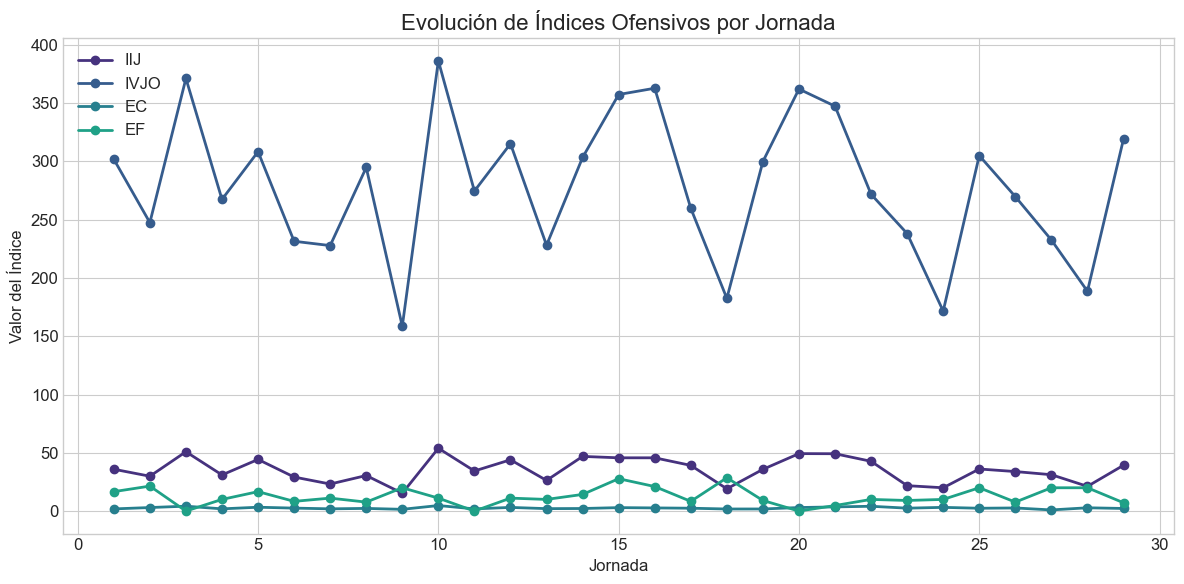

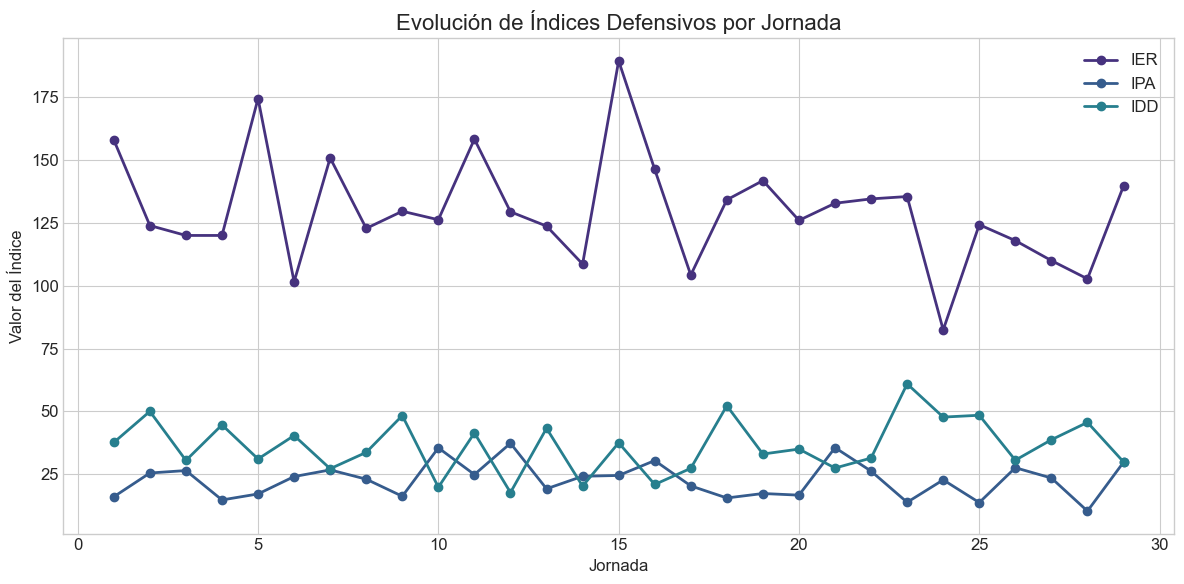

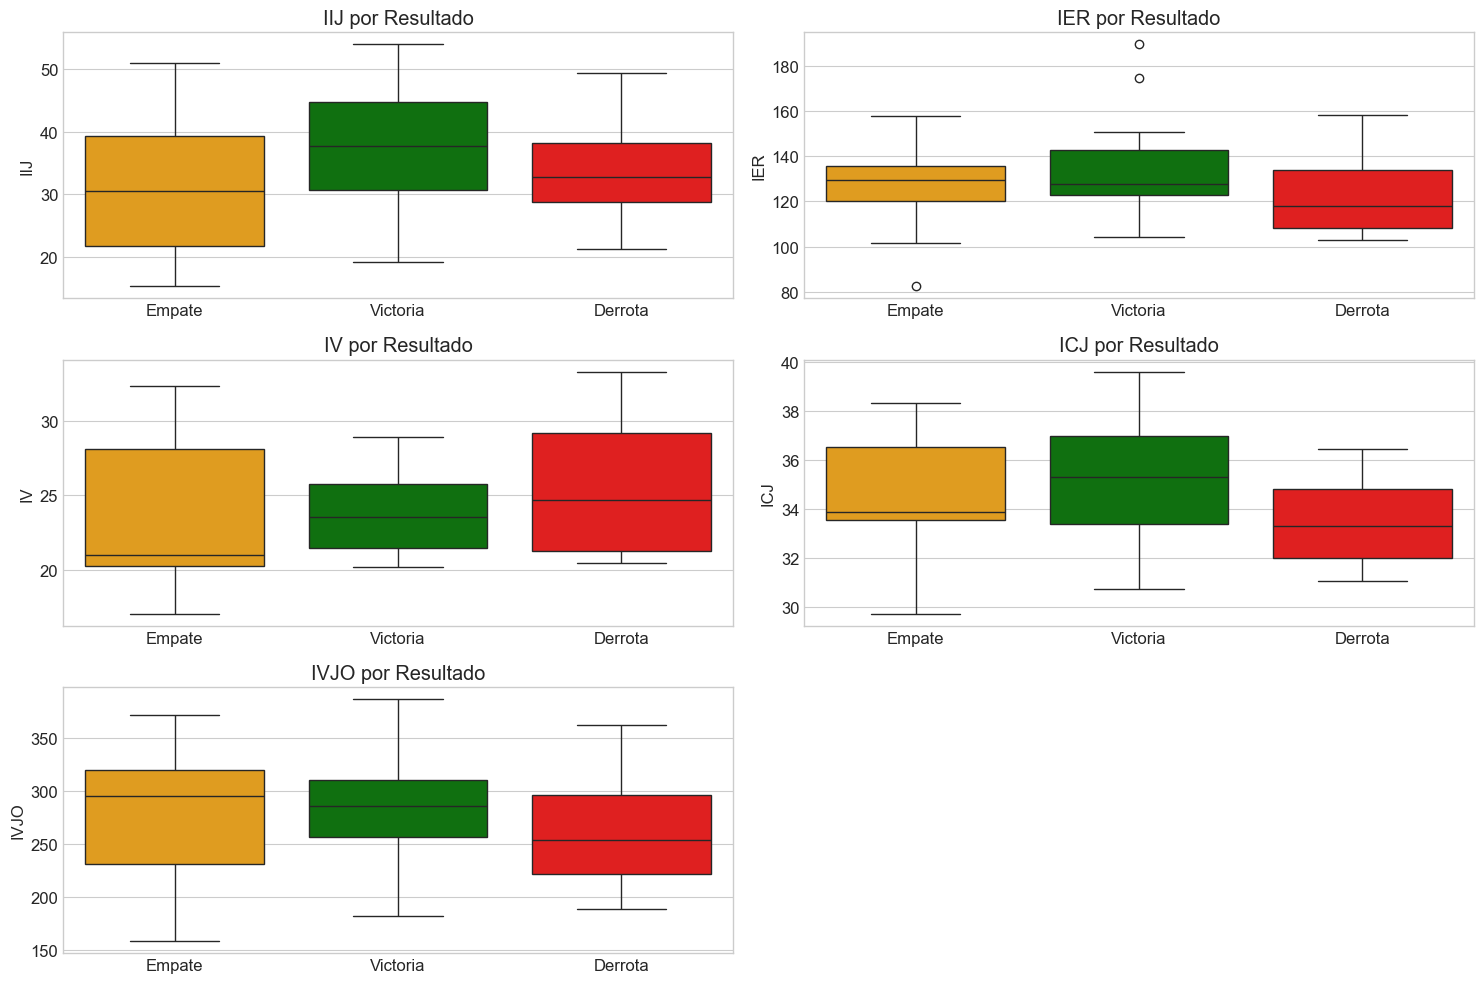

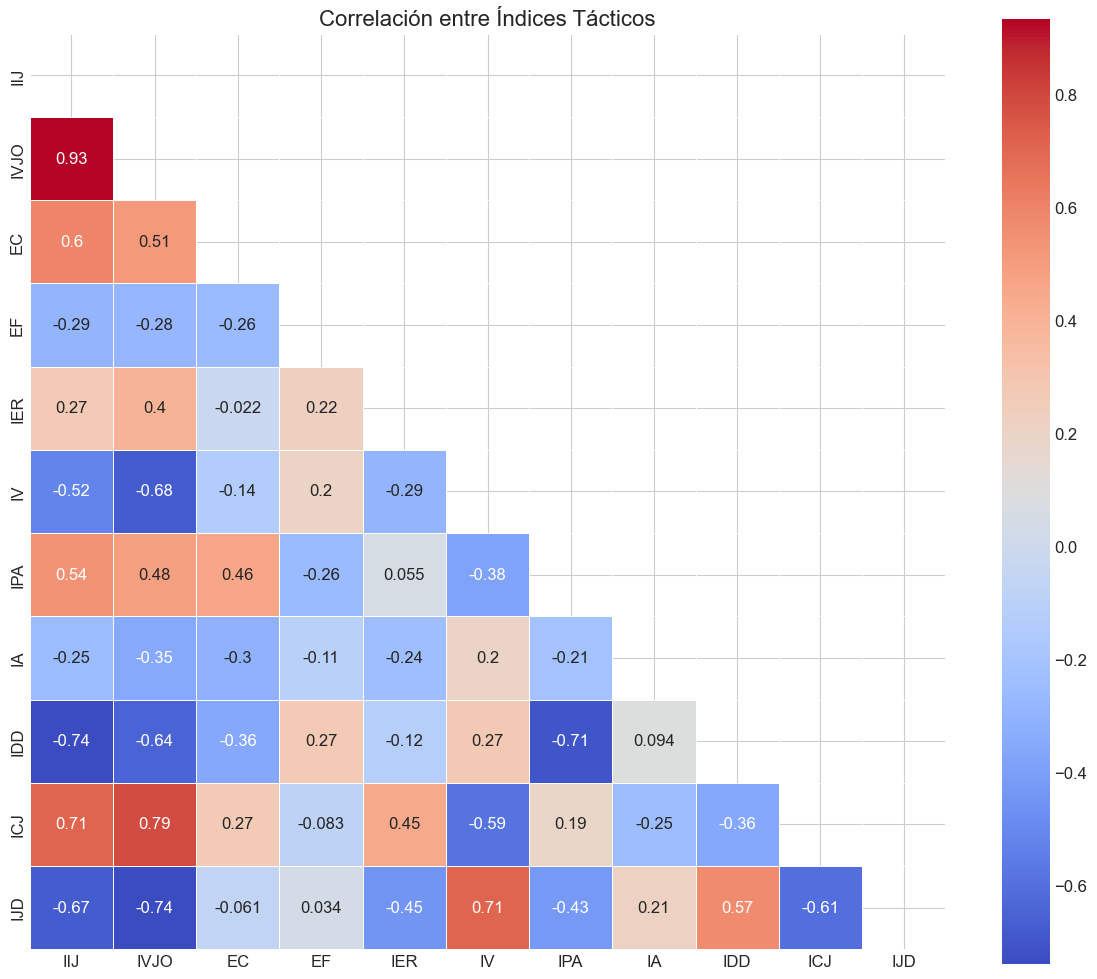


9. Categorizando estilos de juego...
  Asignando categorías de estilo de juego...
Creando categoría estilo_posesion...

Proceso de feature engineering completado.


In [12]:
# Generamos los índices tácticos y derivamos características
df_features = crear_features(datos_limpios)

### <u>A tener en cuenta</u>

Tras analizar la primera prueba he hecho dos cambios importantes:

1. He añadido los nuevos índices a la lista de columnas_requeridas:

- IEO (Índice de Eficiencia Ofensiva)
- IPT (Índice de Precisión Táctica)
- IAB (Índice de Amenaza por Banda)
- ICT (Índice de Control de Transiciones)
- ICP (Índice de Calidad de la Posesión)


2. He incluido 'estilo_posesion' en la lista de categorías de estilos de juego a predecir.

Con estas modificaciones entiendo que el modelo SVM al usar los nuevos índices como características para la clasificación, debería mejorar significativamente su capacidad para categorizar correctamente los estilos de juego en todos los aspectos, incluido el nuevo "estilo_posesion".

### <u>Puntos clave:</u>

- Indices calculados: han sido diseñados para capturar diferentes aspectos del juego, desde la iniciativa ofensiva hasta la complejidad de las jugadas.
- Categorización: las reglas para categorizar estilos se basan en umbrales específicos para cada índice, que podrían ajustarse según los resultados observados.
- Análisis espacial: el código divide el campo en 9 zonas (3x3) para entender mejor dónde ocurren las acciones importantes.
- Secuencias de posesión: se trata de identificar secuencias largas de pases para analizar la complejidad del juego.
- Normalización: para el modelo seleccionado, SVM, se normalizan las variables para que todas tengan un peso similar, independientemente de su escala original.
- Por último, le he dado muchas vueltas a toda la selección de métricas, y he añadido nuevos índices.


### <u>Análisis de resultados</u>

1. Evolución de Índices Ofensivos por Jornada:
- El IVJO (Índice de Volumen de Juego Ofensivo) muestra gran variabilidad, con picos en las jornadas 3, 10, 15-16, 20 y 29. Esto sugiere que el Atlético ajusta significativamente su volumen ofensivo según el contexto.
- El IIJ (Índice de Iniciativa de Juego) es más estable, generalmente entre 40-90, mostrando un enfoque táctico consistente.
- Los índices EC (eficacia en construcción) y EF (eficacia en finalización) son bajos y estables, lo que puede indicar una eficiencia limitada para convertir posesión en ocasiones claras.

2. Evolución de Índices Defensivos por Jornada:
- El IER (índice de fficacia Recuperadora) muestra valores altos y bastante variables (entre 80-180), con picos notables en las jornadas 5, 15 y 24, sugiriendo alta eficacia en recuperación.
- El IPA (índice de presión alta) y el IDD (índice de densidad defensiva) fluctúan considerablemente, indicando adaptación táctica defensiva según el rival.

3. Índices por Resultado:
- El IIJ es mayor en victorias que en empates o derrotas, confirmando que un enfoque más dominante suele conducir al éxito.
- El ICJ (índice de complejidad de juego) es ligeramente más alto en victorias, sugiriendo que secuencias de juego más elaboradas favorecen resultados positivos.
- El IV (índice de verticalidad) es más alto en derrotas, posiblemente indicando que se recurre a juego más directo cuando se va por detrás.

4. Correlación entre Índices:
- Fuerte correlación positiva (0.87) entre IIJ e IVJO, lo cual es lógico ya que ambos miden aspectos de dominio.
- Correlación positiva significativa (0.8) entre IVJO e ICJ, sugiriendo que mayor volumen ofensivo está asociado con juego más elaborado.
- Correlaciones negativas fuertes entre IIJ e IDD (-0.75) y entre IVJO e IJD (-0.82), confirmando la contraposición entre estilos de dominio vs defensivo/directo.
- El IV (verticalidad) tiene correlación positiva (0.7) con IJD (juego directo), lo que tiene sentido táctico.

## 3.3 Preparación para Modelado

### <u>Directrices función preparación de datos para modelado</u>

- Enfoque específico para la preparación del modelado;
- Incluye manejo de errores y advertencias;
- Divide los datos en conjuntos de entrenamiento y prueba;
- Proporciona información sobre las características y categorías seleccionadas;
- Devuelve un scaler que puede ser útil para futuras transformaciones;
- Está documentada con docstrings claros.

In [13]:
def preparar_datos_modelado(df_indices, normalizar=True, test_size=0.3, random_state=42):
    """
    Prepara los datos para modelado SVM, incluyendo normalización,
    selección de características y división en conjuntos de entrenamiento y prueba.
    
    Args:
        df_indices (pd.DataFrame): DataFrame con índices tácticos y categorías
        normalizar (bool): Si True, normaliza las características numéricas
        test_size (float): Proporción del conjunto de prueba (0.0-1.0)
        random_state (int): Semilla para reproducibilidad
    
    Returns:
        dict: Diccionario con datos preparados para modelado:
            - 'X_train', 'X_test': Características de entrenamiento y prueba
            - 'y_train_dict', 'y_test_dict': Diccionarios con etiquetas por categoría
            - 'features': Lista de características usadas
            - 'categorias': Lista de categorías de estilo
            - 'scaler': Objeto scaler para futuras transformaciones
    """
    print("\nPreparando datos para modelado SVM...")
    
    # Selección solo filas con datos completos
    # Añadimos los nuevos índices a la lista de columnas requeridas
    columnas_requeridas = [
        'IIJ', 'IVJO', 'EC', 'EF', 'IER', 'IV', 'IPA', 'IJD', 'IA', 'IDD', 'ICJ',
        # Nuevos índices especializados
        'IEO', 'IPT', 'IAB', 'ICT', 'ICP'
    ]
    
    # Filtrar por columnas disponibles
    columnas_disponibles = [col for col in columnas_requeridas if col in df_indices.columns]
    
    if len(columnas_disponibles) < len(columnas_requeridas):
        print(f"ADVERTENCIA: Faltan algunas columnas requeridas. Usando solo {len(columnas_disponibles)} de {len(columnas_requeridas)}")
    
    # Elimina filas con valores faltantes en las columnas requeridas
    df = df_indices.dropna(subset=columnas_disponibles).copy()
    print(f"Datos filtrados: {df.shape[0]} filas disponibles para modelado")
    
    # Características numéricas para el modelo
    features = columnas_disponibles.copy()
    
    # Añade variables contextuales si están disponibles
    variables_contexto = ['rival_categoria_num', 'es_local']
    for var in variables_contexto:
        if var in df.columns:
            features.append(var)
    
    print(f"Características seleccionadas: {len(features)}")
    print(features)
    
    # Características X para el modelo
    X = df[features].copy()
    
    # Normalizar
    scaler = None
    if normalizar:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X = pd.DataFrame(X_scaled, columns=features, index=X.index)
        print("Datos normalizados con StandardScaler")
    
    # Prepara etiquetas para cada categoría de estilo
    # Actualizamos para incluir la nueva categoría 'estilo_posesion'
    categorias = [
        'orientacion_general', 'fase_ofensiva', 'patron_ataque',
        'intensidad_defensiva', 'altura_bloque', 'tipo_transicion',
        'estilo_posesion'  # Nueva categoría
    ]
    
    # Filtra solo las categorías disponibles
    categorias_disponibles = [c for c in categorias if c in df.columns]
    
    if len(categorias_disponibles) < len(categorias):
        print(f"ADVERTENCIA: Solo {len(categorias_disponibles)} de {len(categorias)} categorías están disponibles")
    
    # Diccionarios para almacenar etiquetas
    y_dict = {}
    
    for categoria in categorias_disponibles:
        y_dict[categoria] = df[categoria]
        print(f"Categoría '{categoria}': {df[categoria].value_counts().to_dict()}")
    
    # Dividir en conjuntos de entrenamiento y prueba    
    X_train, X_test = train_test_split(X, test_size=test_size, random_state=random_state)
    
    # Dividir etiquetas
    y_train_dict = {}
    y_test_dict = {}
    
    for categoria in categorias_disponibles:
        # Asegurarse de que y tenga el mismo índice que X
        y = df[categoria]
        y_train = y.loc[X_train.index]
        y_test = y.loc[X_test.index]
        
        y_train_dict[categoria] = y_train
        y_test_dict[categoria] = y_test
    
    print(f"Conjuntos preparados: {X_train.shape[0]} muestras de entrenamiento, {X_test.shape[0]} muestras de prueba")
    
    # Crear diccionario de resultados
    resultados = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train_dict': y_train_dict,
        'y_test_dict': y_test_dict,
        'features': features,
        'categorias': categorias_disponibles,
        'scaler': scaler
    }
    
    return resultados

In [14]:
# Implementación y visualización de info
print("\n=== 3.3 PREPARACIÓN DE DATOS PARA MODELADO ===")
datos_modelo = preparar_datos_modelado(df_features)

print(f"\nDatos de entrenamiento: {datos_modelo['X_train'].shape}")
print(f"Datos de prueba: {datos_modelo['X_test'].shape}")
print(f"Categorías disponibles: {datos_modelo['categorias']}")


=== 3.3 PREPARACIÓN DE DATOS PARA MODELADO ===

Preparando datos para modelado SVM...
Datos filtrados: 29 filas disponibles para modelado
Características seleccionadas: 18
['IIJ', 'IVJO', 'EC', 'EF', 'IER', 'IV', 'IPA', 'IJD', 'IA', 'IDD', 'ICJ', 'IEO', 'IPT', 'IAB', 'ICT', 'ICP', 'rival_categoria_num', 'es_local']
Datos normalizados con StandardScaler
Categoría 'orientacion_general': {'Defensivo activo': 22, 'Equilibrado': 7}
Categoría 'fase_ofensiva': {'Vertical': 25, 'Posicional': 2, 'Directo': 2}
Categoría 'patron_ataque': {'Equilibrio pasillos de ataque': 29}
Categoría 'intensidad_defensiva': {'Moderada': 11, 'Defensa pasiva reactiva': 9, 'Presión alta agresiva': 9}
Categoría 'altura_bloque': {'Medio': 11, 'Bajo': 9, 'Alto': 9}
Categoría 'tipo_transicion': {'Contragolpe adaptativo': 14, 'Directa ineficiente': 6, 'Elaborada efectiva': 5, 'Elaborada ineficiente': 2, 'Directa efectiva': 2}
Categoría 'estilo_posesion': {'Posesión funcional': 19, 'Posesión eficiente': 10}
Conjuntos pr

# 4. Modelado

## 4.1 Primer Modelo (SVM Support Vector Machines)

He elegido un modelo SVM (Support Vector Machine) fundamentalmente por los siguientes motivos:

- Su eficacia en espacios de alta dimensionalidad: SVM es particularmente efectivo cuando trabajamos con múltiples variables e índices tácticos, manteniendo buen rendimiento incluso cuando el número de características es elevado en comparación con el número de muestras (38 jornadas vs múltiples índices).
- Es capaz de establecer fronteras de decisión complejas: al usar diferentes kernels (lineal, RBF, polinómico), SVM puede capturar relaciones no lineales entre los índices tácticos y los estilos de juego, adaptándose a la complejidad que lleva dicho análisis táctico.
- Es muy robusto frente a posibles outliers: existen partidos con eventos atípicos (expulsiones tempranas, goleadas) pueden ser mejor manejados por SVM, especialmente con la adecuada configuración del parámetro de regularización C.
- Interpretabilidad con SVM lineal: si se usa un kernel lineal, se pueden interpretar los coeficientes del modelo para entender qué índices tienen mayor influencia en la clasificación de cada estilo.
- Y su versatilidad para problemas multiclase: con estrategias como "uno contra todos" (OvA) o "uno contra uno" (OvO), SVM puede abordar eficazmente la naturaleza multiclase de nuestro problema táctico.

In [15]:
# 4.1. Primer modelo (SVM para clasificación de estilos de juego)
def entrenar_modelo_svm(X_train, y_train, optimizar_hiperparametros=True):
    """
    Entrena un modelo SVM para clasificación de estilos de juego
    
    Args:
        X_train (pd.DataFrame): Características de entrenamiento
        y_train (pd.Series): Etiquetas de entrenamiento
        optimizar_hiperparametros (bool): Si True, realiza optimización de hiperparámetros
    
    Returns:
        dict: Diccionario con el modelo entrenado y metadatos:
            - 'modelo': Modelo SVM entrenado
            - 'mejores_parametros': Mejores hiperparámetros (si se optimizó)
            - 'clases': Clases únicas en los datos
    """
    
    
    print(f"Entrenando modelo SVM con {X_train.shape[0]} muestras y {X_train.shape[1]} características")
    print(f"Distribución de clases: {y_train.value_counts().to_dict()}")
    
    resultado = {}
    
    # Optimización de hiperparámetros
    if optimizar_hiperparametros:
        print("Optimizando hiperparámetros mediante GridSearchCV...")
        
        # Definir parámetros a probar
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.1, 0.01],
            'kernel': ['rbf', 'linear']
        }
        
        # Crear y entrenar GridSearchCV
        grid = GridSearchCV(
            SVC(probability=True, random_state=42),
            param_grid,
            cv=5,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1
        )
        
        grid.fit(X_train, y_train)
        
        # Guardar resultados
        print(f"Mejores parámetros encontrados: {grid.best_params_}")
        print(f"Mejor puntuación de validación cruzada: {grid.best_score_:.4f}")
        
        modelo = grid.best_estimator_
        resultado['mejores_parametros'] = grid.best_params_
    else:
        # Entrenar modelo con parámetros predeterminados
        print("Entrenando SVM con parámetros predeterminados...")
        modelo = SVC(kernel='rbf', probability=True, random_state=42)
        modelo.fit(X_train, y_train)
    
    # Guardar modelo y clases
    resultado['modelo'] = modelo
    resultado['clases'] = list(y_train.unique())
    
    return resultado

# Ejemplo de uso:
# Para entrenar el modelo para una categoría específica
categoria = datos_modelo['categorias'][0]  # Primera categoría (por ejemplo, 'orientacion_general')
X_train = datos_modelo['X_train']
y_train = datos_modelo['y_train_dict'][categoria]

# Entrenar modelo
modelo_resultado = entrenar_modelo_svm(X_train, y_train)

# Ahora el modelo está listo para evaluación y predicciones
modelo_entrenado = modelo_resultado['modelo']

Entrenando modelo SVM con 20 muestras y 18 características
Distribución de clases: {'Defensivo activo': 14, 'Equilibrado': 6}
Optimizando hiperparámetros mediante GridSearchCV...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores parámetros encontrados: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor puntuación de validación cruzada: 0.7952


# 5. Evaluación

## 5.1 Evaluación Modelo 1

In [16]:
def evaluar_modelo(modelo, X_test, y_test):
    """
    Evaluar primer modelo
    """
    # Implementar evaluación
    pass

# 6. Despliegue

## 6.1 Preparación para Despliegue

In [17]:
def preparar_despliegue():
    """
    Preparar modelos para despliegue
    """
    # Implementar preparación
    pass

## 6.2 Documentación de Uso

'''
TODO: Documentar:
- Cómo usar los modelos
- Requerimientos
- Limitaciones
- Mantenimiento necesario
'''

# 7. Conclusiones y Recomendaciones
'''
TODO: Documentar:
- Resultados principales
- Interpretación deportiva
- Limitaciones encontradas
- Mejoras propuestas
- Aplicaciones prácticas
'''


if __name__ == "__main__":
    # Ejecución principal
    print("Iniciando análisis...")